# LLM Practical Indaba 2025

<!-- To include imahe -->

<!-- <a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/Foundations_of_LLMs/foundations_of_llms_practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> -->

© Deep Learning Indaba 2025. Apache License 2.0.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1NqTk5JtgcP-pXWzAlKqqROxdoGCNWevz?usp=sharing)


**Authors:**
- Tejumade Afonja
- Annie Qurat Ul Ain
- Jabez Magomere
- Abla Hagani
- Amel Sellami
- Massimo Nicosia
- Sebastian Bodenstein

**Reviewers: [TBD]**

**Introduction:**

[intro to the topic]

**Topics:**

Content: [<font color='orange'>Hugging Face Introduction</font>, <font color='orange'>Transformer Architecture</font>, <font color='green'>Attention Mechanism</font>,  <font color='orange'>Tokenization</font>, <font color='green'>Training your own LLM from scratch</font>]

Level: <font color='orange'>Beginner</font>, <font color='green'>Intermediate</font>

**Aims/Learning Objectives:**

* Understand the idea behind [Attention](https://arxiv.org/abs/1706.03762) and why it is used.
* Present and describe the fundamental building blocks of the [Transformer Architecture](https://arxiv.org/abs/1706.03762) along with an intuition on such an architecture design.
* Compare tokenizers across different languages and analyze how these differences influence the associated monetary costs.
* Build and train your own LLM.

**Prerequisites:**

* Basic knowledge of Deep Learning.
* Familiarity with Natural Language Processing (NLP).
* Basic understanding of Linear Algebra.

**Outline:**

**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

**Suggested experience level in this topic:**

| Level         | Experience                            |
| --- | --- |
`Beginner`      | It is my first time being introduced to this work. |
`Intermediate`  | I have done some basic courses/intros on this topic. |
`Advanced`      | I work in this area/topic daily. |

In [ ]:
# @title **Paths to follow:** What is your level of experience in the topics presented in this notebook? (Run Cell)
experience = 'beginner' #@param ["beginner", "intermediate", "advanced"]
sections_to_follow=''


if experience == 'beginner': sections_to_follow = '''we recommend you to not attempt to do every coding task but instead, skip through to every section and ensure you interact with the LoRA finetuned LLM presented in the last section as well as with the pretrained LLM to get a practical understanding of how these models behave'''

elif experience == 'intermediate': sections_to_follow = '''we recommend you go through every section in this notebook and try the coding tasks tagged as beginner or intermediate. If you get stuck on the code ask a tutor for help or move on to better use the time of the practical'''

elif experience == 'advanced': sections_to_follow = '''we recommend you go through every section and try every coding task until you get it to work'''


print(f'Based on your experience, {sections_to_follow}.\nNote: this is just a guideline, feel free to explore the colab as you\'d like if you feel comfort able!')

Based on your experience, we recommend you to not attempt to do every coding task but instead, skip through to every section and ensure you interact with the LoRA finetuned LLM presented in the last section as well as with the pretrained LLM to get a practical understanding of how these models behave.
Note: this is just a guideline, feel free to explore the colab as you'd like if you feel comfort able!


## [Run Me] Installations, Imports and Helper Functions

In [ ]:
import sys

required_version = (3, 11)
current_version = sys.version_info[:2]

if current_version != required_version:
    print(f"⚠️ Warning: Expected Python {required_version[0]}.{required_version[1]}, but running {current_version[0]}.{current_version[1]}. Some package may not work as expected.")

In [ ]:
# Install necessary libraries for deep learning, NLP, and plotting.
!pip install -q transformers datasets  # Transformers and datasets libraries for NLP tasks.
!pip install -q seaborn umap-learn     # Seaborn for plotting, UMAP for dimensionality reduction.
!pip install -q livelossplot           # LiveLossPlot for tracking model training progress.
!pip install -q peft                # Parameter-Efficient Fine-Tuning library.
!pip install -q accelerate -U          # Accelerate library for performance.
!pip install -q gensim

# Install utilities for debugging and console output formatting.
!pip install -q ipdb                # Interactive Python Debugger
!pip install -q colorama            # Colored terminal text output

# Gemma (note: requires Python >= 3.11)
!pip install -q gemma==3

!pip install -q nltk
!pip install -q torchvision

!pip install -q transformers torch accelerate ipywidgets
!pip install -q colorama
!pip install -q tf-keras

In [ ]:
# Import system and math utilities
import os
import math
import urllib.request
import requests
from PIL import Image
from io import BytesIO


# Check for connected accelerators (GPU or TPU) and set up accordingly
if os.environ.get("COLAB_GPU") and int(os.environ["COLAB_GPU"]) > 0:
    print("A GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
else:
    print("Only CPU accelerator is connected.")

# Avoid GPU memory allocation to be done by JAX
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

# Import libraries for JAX-based deep learning
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax

# Import NLP and model-related libraries
import transformers
from transformers import pipeline, AutoTokenizer
from transformers import BlipProcessor, BlipForQuestionAnswering # For image processing.

from gemma import gm


# Import image processing and plotting libraries
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import additional utilities for working with text and models
import torch
import torchvision
import itertools
import random

# Download an example image to use in the notebook
urllib.request.urlretrieve(
    "https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=80",
    "cat.png",
)

# Import libraries for NLP preprocessing and working with pre-trained models
import gensim
from nltk.data import find
import nltk
nltk.download("word2vec_sample")

# Import Hugging Face tools and IPython widgets
import huggingface_hub
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import colorama

# Set Matplotlib to output SVG format for better quality plots
%config InlineBackend.figure_format = 'svg'

A GPU is connected.


[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


In [ ]:
print("✅ Setup complete!")
print(f"🐍 Python version: {sys.version}")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🤗 Transformers version: {transformers.__version__}")
print(f"💻 CUDA available: {torch.cuda.is_available()}")

✅ Setup complete!
🐍 Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
🔥 PyTorch version: 2.6.0+cu124
🤗 Transformers version: 4.52.4
💻 CUDA available: True


In [ ]:
# @title [Run Me] Helper Plotting Functions.

def plot_position_encodings(P, max_tokens, d_model):
    """
    Plots the position encodings matrix.

    Args:
        P: Position encoding matrix (2D array).
        max_tokens: Maximum number of tokens (rows) to plot.
        d_model: Dimensionality of the model (columns) to plot.
    """

    # Set up the plot size based on the number of tokens and model dimensions
    plt.figure(figsize=(20, np.min([8, max_tokens])))

    # Plot the position encoding matrix with a color map for better visualization
    im = plt.imshow(P, aspect="auto", cmap="Blues_r")

    # Add a color bar to indicate the encoding values
    plt.colorbar(im, cmap="blue")

    # Show embedding indices as ticks if the dimensionality is small
    if d_model <= 64:
        plt.xticks(range(d_model))

    # Show position indices as ticks if the number of tokens is small
    if max_tokens <= 32:
        plt.yticks(range(max_tokens))

    # Label the axes
    plt.xlabel("Embedding index")
    plt.ylabel("Position index")

    # Display the plot
    plt.show()


def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """
    Plots an attention weight matrix with custom axis ticks.

    Args:
        weight_matrix: The attention weight matrix to plot.
        x_ticks: Labels for the x-axis (typically the query tokens).
        y_ticks: Labels for the y-axis (typically the key tokens).
    """

    # Set up the plot size
    plt.figure(figsize=(15, 7))

    # Plot the attention weight matrix as a heatmap
    ax = sns.heatmap(weight_matrix, cmap="Blues")

    # Set custom ticks on the x and y axes
    plt.xticks(np.arange(weight_matrix.shape[1]) + 0.5, x_ticks)
    plt.yticks(np.arange(weight_matrix.shape[0]) + 0.5, y_ticks)

    # Label the plot
    plt.title("Attention matrix")
    plt.xlabel("Attention score")

    # Display the plot
    plt.show()


def load_image_from_url(url):
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        # Check that the content is an actual image
        content_type = response.headers.get("Content-Type", "")
        if not content_type.startswith("image/"):
            raise ValueError(f"Content at URL is not an image. Content-Type: {content_type}")

        return Image.open(BytesIO(response.content)).convert("RGB")

    except:
        print(f"Could not load image from {url}\n ")
        return None

def resize_image(img, new_width=300):
    w, h = img.size
    new_height = int((new_width / w) * h)
    return img.resize((new_width, new_height))

In [ ]:
# @title [Run Me] Helper Text Processing Functions.

def get_word2vec_embedding(words):
    """
    Function that takes in a list of words and returns a list of their embeddings,
    based on a pretrained word2vec encoder.
    """
    word2vec_sample = str(find("models/word2vec_sample/pruned.word2vec.txt"))
    model = gensim.models.KeyedVectors.load_word2vec_format(
        word2vec_sample, binary=False
    )

    output = []
    words_pass = []
    for word in words:
        try:
            output.append(jnp.array(model.word_vec(word)))
            words_pass.append(word)
        except:
            pass

    embeddings = jnp.array(output)
    del model  # free up space again
    return embeddings, words_pass


def remove_punctuation(text):
    """Function that takes in a string and removes all punctuation."""
    import re

    text = re.sub(r"[^\w\s]", "", text)
    return text

def print_sample(prompt, sample, model_name="", generation_time=None):
    html = f"""
    <div style="font-family:monospace; border:1px solid #ccc; padding:10px">
        <div><b style='color:teal;'>🤖 Model:</b> <span>{model_name}</span></div>
        {'<div><b style="color:orange;">⏱️ Generation Time:</b> ' + f'{generation_time:.2f}s</div>' if generation_time else ''}
        <div><b style='color:green;'>📝 Prompt:</b> {prompt}</div>
        <div><b style='color:purple;'>✨ Generated:</b> {sample}</div>
    </div>
    """
    display(HTML(html))


def get_tokenizer(model_name: str):
    """
    Function that takes in a model name and returns the tokenizer for that model.
    """
    if model_name == "gemma3":
        tokenizer = gm.text.Gemma3Tokenizer()
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    return tokenizer


def tokenize(text: str, model_name: str):
    """
    Function that takes in a string and a tokenizer and returns the tokenized version of the string.
    """
    tokenizer = get_tokenizer(model_name)
    token_ids = tokenizer.encode(text)
    tokens = [tokenizer.decode(t) for t in token_ids]
    if model_name != "gemma3":
        tokens = [token.replace('Ġ', ' ') for token in tokens] # Replace the 'Ġ' prefix used by some tokenizers with a space
    return tokens, token_ids

## 🤖 Load a Model from Hugging Face and Interact Locally [<font color='orange'>Beginner</font>] (10 mins)

### 🎯 Objective

- Learn how to **load a model from Hugging Face** and run **inference** using an LLM  
- Load a lightweight model (e.g. `gpt-neo-125m`) and **prompt** it with a simple question
- Experiment with different generation parameters


📚 Welcome to the World of Large Language Models!
We're thrilled to have you on board! 🎉 Before we dive into the hands-on part of our journey, let's take a quick detour into the fascinating world of [Hugging Face](https://huggingface.co/)—an incredible open-source platform for building and deploying cutting-edge language models.

##### 🧠 **What are Large Language Models?**

Large Language Models (LLMs) are AI systems trained on vast amounts of text data to understand and generate human-like text. They work by learning patterns in language and predicting the most likely next word given some context.

**Key concepts:**

*   Pattern Recognition: LLMs analyze billions of words to understand language
*   Next-Word Prediction: At their core, they guess the most probable next word
*   Context Understanding: They consider the entire input when making predictions


#### **About HuggingFace**

<img src="https://www.hugging-face.org/wp-content/uploads/2023/11/hugging-faces.png" alt="Alt Text" width="500">

**HuggingFace** is the "GitHub of AI" - a platform that democratizes access to cutting-edge AI models. Founded in 2016, they provide:

* [Model Hub](https://huggingface.co/models): Thousands of pre-trained models ready to use  
* [Transformers Library](https://huggingface.co/docs/transformers): Easy-to-use tools for working with language models  
* [Datasets](https://huggingface.co/datasets): Curated datasets for training and evaluation  
* [Spaces](https://huggingface.co/spaces): Platform for hosting ML demos and applications  

In this Colab we print prompts in <span style="color:pink;"><b>pink</b></span> and samples generated from a model in <span style="color:blue;"><b>blue</b></span> like in the example below:


In [ ]:
print_sample(prompt='My fake prompt', sample=' is awesome!')

##### **Your First Language Model**

Let's dive into how simple it is to load and interact with a model from **Hugging Face**! 🤗

For this tutorial, we've pre-configured multiple model options for you to experiment with:

* **EleutherAI/gpt-neo-125M** - A lightweight model with 125 million parameters. It’s fast and memory-efficient—great for getting started!
* **gpt2** and **gpt2-medium** - Classic models trained by OpenAI, with 117M and 355M parameters respectively. The medium variant offers more fluency and coherence.
* **tiiuae/falcon-rw-1b** - A larger open-source model from the Falcon family, with 1 billion parameters.
* **microsoft/phi-4** - A cutting-edge model by Microsoft focused on high-quality language generation with smaller memory footprint.

You can switch between these models by restarting the Colab kernel and updating the `model_name` variable in the cell below.

> 💡 **Note:** The loading and interaction steps shown here apply to **any** Hugging Face model that supports text generation via the `pipeline` API. Feel free to explore beyond this list!


Let's generate some text:

In [ ]:
# Set the model name to 'EleutherAI/gpt-neo-125M' (this can be changed via the dropdown options).
model_name = 'gpt2'  # @param ['EleutherAI/gpt-neo-125M', 'gpt2', 'gpt2-medium', 'Qwen/Qwen3-0.6B', 'tiiuae/falcon-rw-1b','microsoft/phi-4']

# Define the prompt for the text generation model.
test_prompt = 'Once upon a time in a magical Kigali'  # @param {type: 'string'}

# Create a text generation pipeline using the specified model.
generator = transformers.pipeline('text-generation', model=model_name)

# Generate text based on the provided prompt.
# 'do_sample=True' enables sampling to introduce randomness in generation, and 'min_length=30' ensures at least 30 tokens are generated.
model_output = generator(test_prompt, do_sample=True, min_length=30)

clear_output() # Clear the output to keep the notebook tidy.

# Print the generated text sample, removing the original prompt from the output.
print_sample(test_prompt, model_output[0]['generated_text'].split(test_prompt)[1].rstrip())

***💡Tip:*** Try running the code above with different prompts or with the same prompt more than once!

***🤔 Discussion:*** Why do you think the generated text changes every time, even with the same prompt? Write your response in the input field below and discuss with your neighbour.

<details>
<summary><strong>Answer</strong></summary>

The model uses sampling with randomness (temperature > 0) to generate diverse outputs.  
Even with the same input, the probabilistic nature of text generation leads to different results.

</details>

#### **Understanding Generation Parameters**

Generation parameters control how the model produces text. Let's explore the most important ones:

### Temperature  
Controls the randomness of predictions:

- **Low (0.1–0.5):** Conservative, predictable outputs  
- **Medium (0.6–1.0):** Balanced creativity and coherence  
- **High (1.1–2.0):** Very creative but potentially incoherent  

### Top-p (Nucleus Sampling)  
Controls diversity by limiting the vocabulary considered:

- **Low (0.1–0.3):** Very focused on most likely words  
- **High (0.8–1.0):** Considers more word possibilities  


Let's experiment with these parameters:


In [ ]:
# @title Choose Model and Prompt { run: "auto" }
model_name = "gpt2"  # @param ["gpt2", "gpt2-medium", "EleutherAI/gpt-neo-125M"]
prompt = "Once upon a time in a magical Kigali,"  # @param {type:"string"}
temperature = 1  # @param {type:"slider", min:0.1, max:1.0, step:0.1}
top_p = 0.2  # @param {type:"slider", min:0.1, max:1.0, step:0.1}
max_new_tokens = 64  # @param {type:"slider", min:10, max:256, step:1}
seed = 2  # @param {type:"integer"}


def run_sample(
    model_name,  # The language model we’ll use to generate text
    prompt: str,  # The text prompt we'll give to the model to start the text generation
    seed: int | None = None,  # Optional: A number to make the results predictable each time
    temperature: float = 0.6,  # Controls how random the model’s output is; lower values make it more focused
    top_p: float = 0.9,  # Controls how much of the most likely words are considered; higher values consider more options
    max_new_tokens: int = 64,  # The maximum number of words or tokens the model will add to the prompt
) -> str:
    # This function generates text based on a given prompt using a language model,
    # with options to control randomness, the number of tokens generated, and reproducibility.

    # Load the model based on selection
    if 'gpt2' in model_name:
        tokenizer = transformers.GPT2Tokenizer.from_pretrained(model_name)
        model = transformers.GPT2LMHeadModel.from_pretrained(model_name)
    elif model_name == "EleutherAI/gpt-neo-125M":
        tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
        model = transformers.AutoModelForCausalLM.from_pretrained(model_name)
    else:
        raise NotImplementedError(f"{model_name} is not yet supported.")

    # Move model to GPU if available
    if torch.cuda.is_available():
        model = model.to("cuda")

    # Align tokenizer padding
    tokenizer.pad_token_id = tokenizer.eos_token_id

    # Convert the prompt text into tokens that the model can process
    inputs = tokenizer(prompt, return_tensors="pt")

    # Extract the tokens (input IDs) and attention mask (to focus on important parts) from the inputs
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Move the tokens and attention mask to the same device as the model (like a GPU if available)
    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)

    # Set up how we want the model to generate text
    generation_config = transformers.GenerationConfig(
        do_sample=True,  # Allow the model to add some randomness to its text generation
        temperature=temperature,  # Adjust how random the output is; lower means more focused
        top_p=top_p,  # Consider the most likely words that make up the top 90% of possibilities
        pad_token_id=tokenizer.pad_token_id,  # Use the token ID that represents padding (extra space)
        top_k=0,  # We're not limiting to the top-k words, so we set this to 0
    )

    # If a seed is provided, set it so that the results are repeatable (same output each time)
    if seed is not None:
        torch.manual_seed(seed)

    # Generate text using the model with the settings we defined
    generation_output = model.generate(
        input_ids=input_ids,  # Provide the input tokens to the model
        attention_mask=attention_mask,  # Provide the attention mask to help the model focus
        return_dict_in_generate=True,  # Ask the model to return detailed information
        output_scores=True,  # Include the scores (confidence levels) for the generated tokens
        max_new_tokens=max_new_tokens,  # Set the maximum number of tokens to generate
        generation_config=generation_config,  # Apply our custom text generation settings
    )

    # Make sure only one sequence (output) is generated, to keep things simple
    assert len(generation_output.sequences) == 1

    # Get the generated sequence of tokens
    output_sequence = generation_output.sequences[0]

    # Convert the generated tokens back into readable text
    output_string = tokenizer.decode(output_sequence)

    # Print the prompt and the generated response
    print_sample(prompt, output_string)

    # Return the generated text response
    return output_string

# Run the interactive generation
_ = run_sample(
    model_name=model_name,
    prompt=prompt,
    temperature=temperature,
    top_p=top_p,
    seed=seed,
    max_new_tokens=max_new_tokens
)


**🎯 Try This:** Experiment with different prompts and temperature values. What patterns do you notice?


#### **Language Models in Real-World Applications**

Language models have many practical applications. Let's explore a few:

**Code Generation**

In [ ]:
code_prompt = 'Write a Python function that calculates the fibonacci sequence:' # @param {type:'string'}
model_name = 'gpt2'  # @param ['gpt2', 'gpt2-medium', 'EleutherAI/gpt-neo-125M']
code_result = run_sample(model_name, code_prompt, temperature=0.3, max_new_tokens=200)
print('💻 Code Generation:')
print(code_result)

💻 Code Generation:
Write a Python function that calculates the fibonacci sequence:

def fibonacci ( x ): return ( x * x + 1 ) + 1

This is a very simple example, but it is a good starting point for the next step.

The next step is to generate a function that returns a Fibonacci sequence.

def fibonacci ( x ): return ( x * x + 1 ) + 1

This is a very simple example, but it is a good starting point for the next step.

The next step is to generate a function that returns a Fibonacci sequence.

def fibonacci ( x ): return ( x * x + 1 ) + 1

This is a very simple example, but it is a good starting point for the next step.

The next step is to generate a function that returns a Fibonacci sequence.

def fibonacci ( x ): return ( x * x + 1 ) + 1

This is a very simple


**Question Answering**

In [ ]:
qa_prompt = 'What are the main advantages of using version control in software development?' # @param {type:'string'}
model_name = 'gpt2'  # @param ['gpt2', 'gpt2-medium', 'EleutherAI/gpt-neo-125M']
qa_result = run_sample(model_name, qa_prompt, temperature=0.5, max_new_tokens=80)

**Creative Writing**

In [ ]:
story_prompt = 'Write the opening paragraph of a science fiction story:' # @param {type:'string'}
model_name = 'gpt2'  # @param ['gpt2', 'gpt2-medium', 'EleutherAI/gpt-neo-125M']
story_result = run_sample(model_name, story_prompt, temperature=0.9, max_new_tokens=100)

**Vision Question Answering**

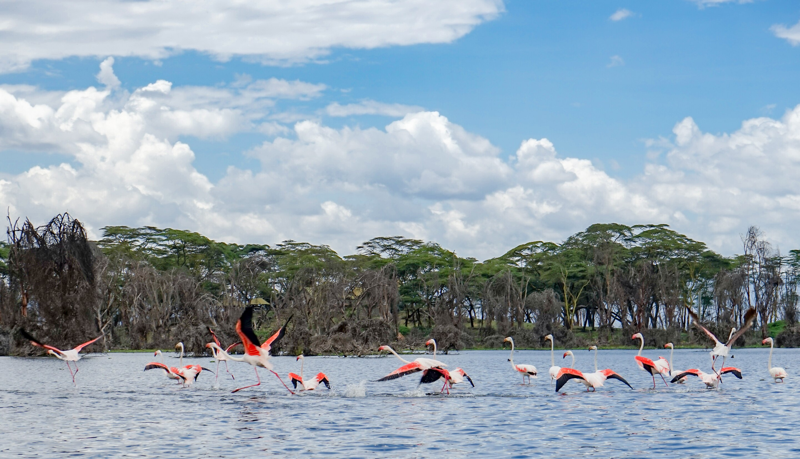

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Lake_Naivasha%2C_Kenya_%2832487531978%29.jpg/2880px-Lake_Naivasha%2C_Kenya_%2832487531978%29.jpg" # @param {type:'string'}
image = load_image_from_url(image_url)
display(resize_image(image, new_width=800))

# Ask a question
question = "What is in the picture?" # @param {type:'string'}

# Load model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# Prepare inputs
inputs = processor(image, question, return_tensors="pt")

# Run inference
with torch.no_grad():
    output = model.generate(**inputs)

# Decode and print the answer
answer = processor.decode(output[0], skip_special_tokens=True)
print('')
print_sample(question, answer)

**Chatbot**

In [ ]:
model = gm.nn.Gemma3_1B()
params = gm.ckpts.load_params(gm.ckpts.CheckpointPath.GEMMA3_1B_IT)

sampler = gm.text.ChatSampler(
    model=model,
    params=params,
    multi_turn=True,
)

user = 'Share one metaphor linking "shadow" and "laughter".' # @param {type:'string'}

turn0 = sampler.chat(user)
print_sample(user, turn0)

In [ ]:
user = 'Expand it in a haiku.' # @param {type:'string'}
turn1 = sampler.chat(user)
print_sample(user, turn1)

Pretty cool, right? 🤩 While this might have seemed revolutionary back in 2021, many of you have probably interacted with **Large Language Models (LLMs)** by now.  

Today, we're going to take things a step further — by **training our own Shakespeare-inspired LLM**! This hands-on experience will help us understand how these models actually work **under the hood**.

But before we dive into training, we need to build a **solid foundation**.  
We'll start by exploring what **Large Language Models** really are, and review the **core machine learning concepts** behind this powerful technology.

At the heart of today's **state-of-the-art (SoTA)** LLMs are two key ideas:  

*   🔹 The **Transformer Architecture**
*   🔹 The **Attention Mechanism**



Let's unpack both of these in the next sections of the tutorial. 🚀💡



## 🔍 Transformer Architecture [<font color='orange'>Beginner</font>] Quick Recap (1 min)

The Transformer Architecture was famously introduced in the paper entitled [Attention is all you need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) by Vaswani et al.

As the title of the paper suggests, such an architecture consists of basically only attention mechanisms along with feed-forward layers and linear layers, as shown in the diagram below.

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width="350" />

Transformers and its variations are in the core of Large Language Models and it's not an exaggeration to say that almost all language models out there are Transformer based architectures.

As you can see in the diagram the original Transformer architecture consists of two parts, one that receives inputs usually called encoder and another that receives outputs (i.e. targets) called decoder. This is because the transformer was designed for machine translation.

In this tutorial, we will focus only on the decoder part which is the architecture that powers most modern large language models like ChatGPT.

<img src="https://drive.google.com/uc?export=view&id=1MubUcshJTHCqOPTRHixLhrYYLXX9vP_h" alt="drawing" width="260"/>

The decoder block consists of $N$ identical blocks with different parts such as:

1. A masked multi-head attention block. This is an MHA block that performs _self-attention_ on the output sequence however this computation is restricted to the inputs that have already been seen. In other words, future tokens are blocked when making predictions.
2. A Multi-layer Perceptron (MLP) or Feed forward layer.
4. Residual connection.




## 🔍 Attention [<font color='green'>Intermediate</font>] (25 mins)

### 🎯 Objective:

- Implement **attention**, **masked attention**, and **multi-head attention**
- Explore **visualizations** to understand each mechanism
- Implement **self-attention**
- Write code to compute **Q (Query)**, **K (Key)**, and **V (Value)** vectors  
- Implement **masked self-attention**
- Build **multi-head attention** from self-attention

### From RNNs to Transformers


RNNs are particularly effective in capturing short-term dependencies in sequences. However, they suffer from the vanishing gradient problem, where the influence of earlier inputs diminishes exponentially as the sequence progresses, making it difficult to capture long-term dependencies.


<figure>
  <img src="https://drive.google.com/uc?export=view&id=17SK-eyFNUdg9WPToZt6QEq_XwkO8p5Y9" alt="Positional Encoding Vectors" width="800"/>
  <figcaption><em></em></figcaption>
</figure>

When leveraging NLP kind of tasks, an encoder-decoder architecture is used:

* The encoder transforms the input sequence into a fixed-length context vector summarizing the input.
* The decoder then generates the output sequence using this context vector to initialize its hidden state.

<figure>
  <img src="https://drive.google.com/uc?export=view&id=1qAr639VTfxTSXy16W_llYxS7SsVPXImv" alt="Positional Encoding Vectors" width="800"/>
  <figcaption><em></em></figcaption>
</figure>

RNNs problems:


1. Slow computation for long sequences
2. Vanishing or exploding gradients
3. Difficulty in accessing information from long time ago1. Slow computation for long sequences

Solution?

### Attention is all you need


Imagine you're looking for a book in a library based on a brief description.
The sentence you hear is: “It’s about a young wizard ⚡🧙‍♂️👓 who attends a magical school.”
You don’t focus on every word equally — your mind zooms in on “wizard” and “magical school 🎩 🏰”. These are the keywords that trigger your memory and help you immediately think of Harry Potter🦉📬

The Attention mechanism is based on a common-sensical intuition that we “attend to” a certain part when processing a large amount of information.

Note: The Attention mechanism enables the transformers to have extremely long-term memory. A transformer model can “attend” or “focus” on all previous tokens that have been generated.


In order to understand the entire sentence, we will learn to correlate and attend to certain words based on the context of the entire sentence.


<figure>
  <img src="https://drive.google.com/uc?export=view&id=1sa9lVMIA6y6H-hvZwFSoc6B3TxQ_a6yd" alt="Positional Encoding Vectors" width="800"/>
  <figcaption><em></em></figcaption>
</figure>


For instance, in the first sentence in the image above, when looking at the word "coding", we pay more attention to the word "Apple" and "computer" because we know that when we speak about coding, "Apple" is actually referring to the company. However, in the second sentence, we realise we should not consider " apple " when looking at "code" because given the context of the rest of the sentence, we know that this apple is referring to an actual apple and not a computer.

We can build better models by developing mechanisms that mimic attention. It will enable our models to learn better representations of our input data by contextualising what it knows about some parts of the input based on other parts. In the following sections, we will explore the mechanisms that enable us to train deep learning models to attend to input data in the context of other input data.


### How Machines Learn to Pay Attention (Like We Do)

One way to implement attention in neural networks is by representing each word (or even parts of a word) as a vector.

So, what’s a vector? A vector is simply an array of numbers (called real-valued numbers) that can have different lengths. Think of it like a list of values that describe certain properties of a word. These vectors allow us to measure how similar two words are to each other. One common way to measure this similarity is by calculating something called the dot product.

<figure>
  <img src="https://drive.google.com/uc?export=view&id=1mReprFfL9ezlIRh55Co0yzX3EjiwcHsf" alt="Positional Encoding Vectors" width="800"/>
  <figcaption><em></em></figcaption>
</figure>

To illustrate how the dot product can create meaningful attention weights, we'll use pre-trained word2vec embeddings. These word2vec embeddings are generated by a neural network that learned to create similar embeddings for words with similar meanings.

By calculating the matrix of dot products between all vectors, we get an attention matrix. This will indicate which words are correlated and therefore should "attend" to each other.

In [ ]:
def dot_product_attention(hidden_states, previous_state):
    """
    Calculate the dot product between the hidden states and previous states.

    Args:
        hidden_states: A tensor with shape [T_hidden, dm]
        previous_state: A tensor with shape [T_previous, dm]
    """

    # Hint: To calculate the attention scores, think about how you can use the `previous_state` vector
    # and the `hidden_states` matrix. You want to find out how much each element in `previous_state`
    # should "pay attention" to each element in `hidden_states`. Remember that in matrix multiplication,
    # you can find the relationship between two sets of vectors by multiplying one by the transpose of the other.
    # Hint: Use `jnp.matmul` to perform the matrix multiplication between `previous_state` and the
    # transpose of `hidden_states` (`hidden_states.T`).
    scores = ...  # FINISH ME

    # Hint: Now that you have the scores, you need to convert them into probabilities.
    # A softmax function is typically used in attention mechanisms to turn raw scores into probabilities
    # that sum to 1. This will help in determining how much focus should be placed on each hidden state.
    # Hint: Use `jax.nn.softmax` to apply the softmax function to `scores`.
    w_n = ...  # FINISH ME

    # Multiply the weights by the hidden states to get the context vector
    # Hint: Use `jnp.matmul` again to multiply the attention weights `w_n` by `hidden_states`
    # to get the context vector.
    c_t = jnp.matmul(w_n, hidden_states)

    return w_n, c_t

In [ ]:

# @title Run me to test your code

key = jax.random.PRNGKey(42)
x = jax.random.normal(key, [2, 2])

try:
  w_n, c_t = dot_product_attention(x, x)

  w_n_correct = jnp.array([[0.9567678, 0.04323225], [0.00121029, 0.99878967]])
  c_t_correct = jnp.array([[0.11144122, 0.95290256], [-1.5571996, -1.5321486]])
  assert jnp.allclose(w_n_correct, w_n), "w_n is not calculated correctly"
  assert jnp.allclose(c_t_correct, c_t), "c_t is not calculated correctly"

  print("It seems correct. Look at the answer below to compare methods.")
except:
  print("It looks like the function isn't fully implemented yet. Try modifying it.")

It looks like the function isn't fully implemented yet. Try modifying it.


In [ ]:

# when changing these words, note that if the word is not in the original
# training corpus it will not be shown in the weight matrix plot.
# @title Answer to code task (Try not to peek until you've given it a good try!')
def dot_product_attention(hidden_states, previous_state):
    # Calculate the attention scores:
    # Multiply the previous state vector by the transpose of the hidden states matrix.
    # This gives us a matrix of scores that show how much attention each element in the previous state
    # should pay to each element in the hidden states.
    # The result is a matrix of shape [T, N], where:
    # T is the number of elements in the hidden states,
    # N is the number of elements in the previous state.
    scores = jnp.matmul(previous_state, hidden_states.T)

    # Apply the softmax function to the scores to convert them into probabilities.
    # This normalizes the scores so that they sum up to 1 for each element,
    # allowing us to interpret them as how much attention should be given to each hidden state.
    w_n = jax.nn.softmax(scores)

    # Calculate the context vector (c_t):
    # Multiply the attention weights (w_n) by the hidden states.
    # This combines the hidden states based on how much attention each one deserves,
    # resulting in a new vector that represents the weighted sum of the hidden states.
    # The resulting shape is [T, d], where:
    # T is the number of elements in the previous state,
    # d is the dimension of the hidden states.
    c_t = jnp.matmul(w_n, hidden_states)

    # Return the attention weights and the context vector.
    return w_n, c_t

/tmp/ipython-input-7-3761503219.py:17: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(jnp.array(model.word_vec(word)))


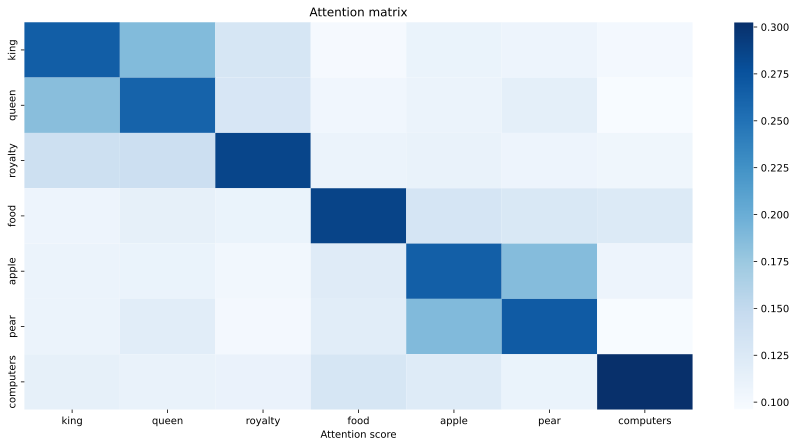

In [ ]:
words = ["king", "queen", "royalty", "food", "apple", "pear", "computers"]
word_embeddings, words = get_word2vec_embedding(words)
weights, _ = dot_product_attention(word_embeddings, word_embeddings)
plot_attention_weight_matrix(weights, words, words)

Looking at the matrix, we can see which words have similar meanings. The "royal" group of words have higher attention scores with each other than the "food" words, which all attend to one another. We also see that "computers" have very low attention scores for all of them, which shows that they are neither very related to "royal" or "food" words.

Note: Dot product is only one of the ways to implement the scoring function for attention mechanisms, there is a more extensive list in this [blog post](https://lilianweng.github.io/posts/2018-06-24-attention/) by Dr Lilian Weng.

### Between Self Attention & Multi Head attention

Self-attention and multi-head attention (MHA) are fundamental components of the transformer architecture. In this section, we'll thoroughly explain the intuition behind these concepts and their implementation. Later, in the Transformers section, you'll learn how these attention mechanisms are used to create a sequence-to-sequence model that relies entirely on attention.

As we move forward, we'll represent sentences by breaking them down into individual words and encoding each word using the word2vec model discussed earlier. In the Transformers section, we'll explore in more detail how input sequences are transformed into a series of vectors.

In [ ]:
def embed_sentence(sentence):
    """
    Embed a sentence using word2vec; for example use cases only.
    """
    # clean sentence (not necessary if using a proper LLM tokenizer)
    sentence = remove_punctuation(sentence)

    # extract individual words
    words = sentence.split()

    # get the word2vec embedding for each word in the sentence
    word_vector_sequence, words = get_word2vec_embedding(words)

    # return with extra dimension (useful for creating batches later)
    return jnp.expand_dims(word_vector_sequence, axis=0), words

### Self Attention

A simple question about this sentence is what the word "it" refers to? Even though it might look simple, it can be tough for an algorithm to learn this. This is where self-attention comes in, as it can learn an attention matrix for the word "it" where a large weight is assigned to the word "animal".

Self-attention also allows the model to learn how to interpret words with the same embeddings, such as apple, which can be a company or food, depending on the context. This is very similar to the hidden state found within an RNN, but this process, as you will see, allows the model to attend over the entire sequence in parallel, allowing longer sequences to be utilised.

Self-attention consists of three concepts:

* Queries, keys and values
* Scaled dot product attention
* Masks


$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$


<figure>
  <img src="https://drive.google.com/uc?export=view&id=1VwPK-JVOe_NyY4QwKcaCxp4YGpxVIu1u" alt="Positional Encoding Vectors" width="800"/>
  <figcaption><em></em></figcaption>
</figure>

In [ ]:
class SequenceToQKV(nn.Module):
  output_size: int

  @nn.compact
  def __call__(self, X):

    # define the method for weight initialisation
    initializer = nn.initializers.variance_scaling(scale=0.5, mode="fan_in", distribution="truncated_normal")

    # initialise three linear layers to do the QKV transformations.
    # note: this can also be one layer, how do you think you would do it?
    q_layer = nn.Dense(self.output_size, kernel_init=initializer)
    k_layer = nn.Dense(self.output_size, kernel_init=initializer)
    v_layer = nn.Dense(self.output_size, kernel_init=initializer)

    # transform and return the matrices
    Q = q_layer(X)
    K = k_layer(X)
    V = v_layer(X)

    return Q, K, V

But what's the query, Key and values?

🎯 Real-Life Analogy:
Imagine you're in a library, trying to find the most relevant facts for a question.

* You have a question in mind: that’s your query.

* Each book in the library has a title or description: that's its key.

* Inside each book is the actual content: that’s the value.

In self-attention, every word in a sentence plays all three roles:

* It creates a query: "What am I looking for?"

* It presents a key: "What information do I contain?"

* It offers a value: "Here’s what I can contribute."


In general:
* Self-Attention is permutation invariant.

* Self-Attention requires no parameters. Up to now the interaction between words
has been driven by their embedding and the positional encodings.

* We expect values along the diagonal (of the Matrix) to be the highest.

* If we don’t want some positions to interact, we can always set their values to –∞

Conclusion: Self-Attention allows the model to relate words to each other.

## Scaled dot product attention
Now that we have our `query`, `key` and `value` matrices, it is time to calculate the attention matrix. Remember, in all attention mechanisms; we must first find a score for each vector in the sequence and then use these scores to create a new context vector. In self-attention scoring is done using scaled dot product attention, and then the normalised scores are used as weights to sum the value vectors and create the context vector.

$\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$

where the attention scores are calculated by $\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right)$ and the scores are then multiplied by $V$ to get the context vector.


What happens here is similar to what we did in the dot product attention in the previous section, just applying the mechanism to the sequence itself. For each element in the sequence, we calculate the attention weight matrix between $q_i$ and $K$. We then multiply $V$ by each weight and finally sum all weighted vectors $v_{weighted}$ together to form a new representation for $q_i$. By doing this, we are essentially drowning out irrelevant vectors and bringing up important vectors in the sequence when our focus is on $q_1$.

$QK^\top$ is scaled by the square root of the dimension of the vectors, $\sqrt{d_k}$, to ensure more stable gradients during training.

In [ ]:
def scaled_dot_product_attention(query, key, value):
    """
    Formula to return scaled dot product attention given QKV matrices
    """
    d_k = key.shape[-1]

    # get the raw scores (logits) from dot producting the queries and keys
    logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))

    # scale the raw scores and apply the softmax function to get the attention scores/weights
    scaled_logits = logits / jnp.sqrt(d_k)
    attention_weights = jax.nn.softmax(scaled_logits, axis=-1)

    # multiply the weights by the value matrix to get the output
    output = jnp.matmul(attention_weights, value)

    return output, attention_weights


Let's now see scaled dot product attention in action. We will take a sentence, embed each word using word2vec, and see what the final self-attention weights look like.

We will not use the linear projection layers we would need to train these. Instead, we are going to make things simple and use $X=Q=V=K$.

/tmp/ipython-input-7-3761503219.py:17: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(jnp.array(model.word_vec(word)))


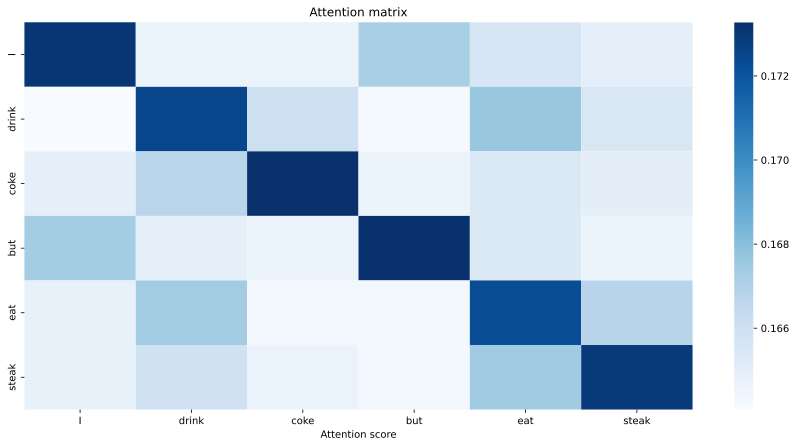

In [ ]:
# define a sentence
sentence = "I drink coke, but eat steak"

# embed and create QKV matrices
word_embeddings, words = embed_sentence(sentence)
Q = K = V = word_embeddings

# calculate weights and plot
outputs, attention_weights = scaled_dot_product_attention(Q, K, V)

# plot the words and the attention weights between them
words = remove_punctuation(sentence).split()
plot_attention_weight_matrix(attention_weights[0], words, words)

Keep in mind that we have not trained our attention matrix yet. However, we can see that by utilising the word2vec vectors as our sequence, we can see how scaled dot product attention already is capable of attending to "eat" when "steak" is our query and that the query "drink" attends more to "coke" and "eat".

More resources:

[Attention with Q,K,V](https://www.youtube.com/watch?v=k-5QMalS8bQ&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=7)

### Masked Attention

Masked attention is a technique used in attention mechanisms—especially in Transformers—to prevent a model from "looking ahead" when it shouldn't.

📚 Intuition: Like Reading Without Spoilers
Imagine you're reading a mystery novel one chapter at a time. You want to guess who the culprit is without skipping ahead to the end. Masked attention works the same way:

'At position t, the model is only allowed to attend to tokens at or before time t, not after.'


🕵️‍♂️ Why Use Masked Attention?

🧱 Padding in Uneven-Length Sequences
When batching sequences (e.g., sentences or time series) of different lengths, we usually pad the shorter ones so all sequences have the same length. But those padding tokens are just placeholders—they carry no real information.

❗ If we don’t mask them, the model might treat padding as meaningful content, which can confuse learning.


2. 🔒 Preventing Look-Ahead in Decoder Models
In models that generate sequences (like GPT), we train them using the full output sentence at once. But during actual generation, the model should only see past and present tokens—not the future ones.

🧠 Imagine writing a story one word at a time. You shouldn't be allowed to read ahead before writing the next word!

<img src="https://windmissing.github.io/NLP-important-papers/AIAYN/assets/5.png" alt="drawing" width="200"/>.



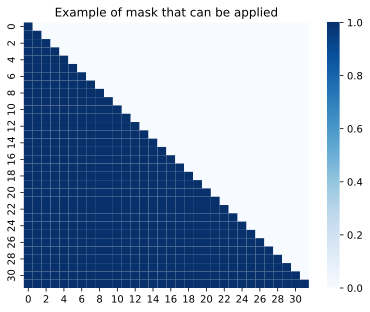

In [ ]:
# example of building a mask for tokens of size 32
# the mask makes sure that positions only attend to previous positions in the input (causal mask)
# we will use this later to insert -inf values into the raw scores
mask = jnp.tril(jnp.ones((32, 32)))

# plot
sns.heatmap(mask, cmap="Blues")
plt.title("Example of mask that can be applied");

Lets now adapt our scaled dot product attention function to implement masked attention.

In [ ]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Scaled dot product attention with a causal mask (only allowed to attend to previous positions)
    """
    d_k = key.shape[-1]
    T_k = key.shape[-2]
    T_q = query.shape[-2]

    # get scaled logits using dot product as before
    logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
    scaled_logits = logits / jnp.sqrt(d_k)

    # add optional mask where values along the mask are set to -inf
    if mask is not None:
        scaled_logits = jnp.where(mask[:T_q, :T_k], scaled_logits, -jnp.inf)

    # calcualte the attention weights via softmax
    attention_weights = jax.nn.softmax(scaled_logits, axis=-1)

    # sum with the values to get the output
    output = jnp.matmul(attention_weights, value)

    return output, attention_weights

### The beast with many heads: Multi-Head attention


We talked about self attention mechanisim in the last section, How does the multi-head attention relate to the self-attention mechanism (scaled-dot product attention)?

<figure>
  <img src="https://drive.google.com/uc?export=view&id=1e0C2tC29XylPRVfwXo_-NLzisQbLIdxl" alt="Positional Encoding Vectors" width="800"/>
  <figcaption><em></em></figcaption>
</figure>

Multi-head self-attention is a variant of self-attention used in the Transformer model. It involves running multiple sets of attention computations in parallel, each focusing on different relationships and aspects of the input sequence.
rather than only computing the attention once, the MHA mechanism runs through the scaled dot-product attention multiple times in parallel. According to the paper, Attention is All You Need, "multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this."

Multi-head attention can be viewed as a similar strategy to stacking convolution kernels in a CNN layer. This allows the kernels to focus on and learn different features and rules, which is why multiple heads of attention also work.

<figure>
  <img src="https://drive.google.com/uc?export=view&id=1ulHkifKMzFSHl7-pJnUpc5VP-H2FssED" alt="Positional Encoding Vectors" width="800"/>
  <figcaption><em></em></figcaption>
</figure>

Or more precisely something like this: A stack of scaled dot product attention


<figure>
  <img src="https://drive.google.com/uc?export=view&id=1lfMZAgs6bR5_0blSB95SAPuX1TNpNaCC" alt="Positional Encoding Vectors" width="500"/>
  <figcaption><em></em></figcaption>
</figure>



Let's take a look at how to implement multi-head attention. In simple terms, multi-head attention is like running the attention process multiple times in parallel, using different copies of the Q, K, and V matrices for each "head." This helps the model focus on different parts of the input at the same time. If you're interested in learning more, check out [this blog by Sebastian Raschka](https://magazine.sebastianraschka.com/p/understanding-and-coding-self-attention) for a detailed explanation.

In [ ]:
class MultiHeadAttention(nn.Module):
    num_heads: int  # Number of attention heads
    d_m: int  # Dimension of the model's embeddings

    def setup(self):
        # Initialize the sequence-to-QKV transformation module
        self.sequence_to_qkv = SequenceToQKV(self.d_m)

        # Define the initializer for the output linear layer weights
        initializer = nn.initializers.variance_scaling(
            scale=0.5, mode="fan_in", distribution="truncated_normal"
        )

        # Initialize the output projection layer Wo (used after attention)
        self.Wo = nn.Dense(self.d_m, kernel_init=initializer)

    def __call__(self, X=None, Q=None, K=None, V=None, mask=None, return_weights=False):
        # If Q, K, or V are not provided, use the input X to generate them
        if None in [Q, K, V]:
            assert not X is None, "X has to be provided if either Q, K, or V are not provided"

            # Generate Q, K, and V matrices from the input X
            Q, K, V = self.sequence_to_qkv(X)

        # Extract the batch size (B), sequence length (T), and embedding size (d_m)
        B, T, d_m = K.shape

        # Calculate the size of each attention head's embedding (d_m / num_heads)
        head_size = d_m // self.num_heads

        # Reshape Q, K, V to have separate dimensions for the heads
        # B, T, d_m -> B, T, num_heads, head_size -> B, num_heads, T, head_size
        q_heads = Q.reshape(B, T, self.num_heads, head_size).swapaxes(1, 2)
        k_heads = K.reshape(B, T, self.num_heads, head_size).swapaxes(1, 2)
        v_heads = V.reshape(B, T, self.num_heads, head_size).swapaxes(1, 2)

        # Apply scaled dot-product attention to each head
        attention, attention_weights = scaled_dot_product_attention(
            q_heads, k_heads, v_heads, mask
        )

        # Reshape the attention output back to its original dimensions
        # (B, num_heads, T, head_size) -> (B, T, num_heads, head_size) -> (B, T, d_m)
        attention = attention.swapaxes(1, 2).reshape(B, T, d_m)

        # Apply the output linear transformation Wo to the attention output
        X_new = self.Wo(attention)

        # If return_weights is True, return both the transformed output and attention weights
        if return_weights:
            return X_new, attention_weights
        else:
            # Otherwise, return just the transformed output
            return X_new

## What to keep in mind:

🔍 Attention:

* Captures long-range dependencies.

* Enables parallelization (unlike RNNs).

* Attention is position-agnostic unless combined with positional encoding.


💡 Masked attention :

* Causal mask (look-ahead): Ensures autoregressive behavior (e.g., token t sees only tokens ≤ t).

* Padding mask: Prevents attention to meaningless padded positions.

* Implemented by masking attention logits before softmax using -inf.

✨ Multi Head Attention

* Don’t just look one way—look at multiple patterns at once

* Helps capture multiple types of dependencies (e.g., syntax, semantics).

In the next section, we will look at how to prepare the input text data for the transformer architecture.

## 🧱 Tokenization [<font color='orange'>Beginner</font>] (10 minutes)


### Objective
* Walk away with knowledge of how your language is tokenized and what cost implications that has


### Have you ever thought about how a language model reads your text?

Language models don't "read" text the way we do—as strings of words forming coherent sentences. Instead, they break down the texts into smaller units called *tokens*. These tokens are then converted into numbers (token ID) that the model actually uses during training or inference. The process of breaking text into smaller component is called *tokenization*.

A token can be:

* A single character (`i`, `n`, `d`, `a`, `b`)
* A subword (`ind`, `aba`)
* A whole word (`indaba`)

Different models—like GPT, Gemma, LLaMA, Mistral, and others—use different tokenizers, and each makes its own decisions about how to break text into tokens. The most common tokenization method used in LLMs is **Byte Pair Encoding (BPE)**. If you’re curious about how it works, this [excellent video](https://www.youtube.com/watch?v=zduSFxRajkE) explains really well.

> The key idea behind tokenization is **granularity**—how small should a model break text down in order to understand and predict what comes next? The goal is to find a balance: break text into small enough pieces that the model can generalize well, but not so small that it explodes the number of tokens. A good tokenizer keeps the vocabulary compact, handles diverse languages efficiently, and compresses text well so that fewer tokens are needed to represent meaning—especially across multilingual inputs.

### **🎯 Try it Yourself:** Tokenizer Playground

Let's make this real. Visit any of these:

* [Tiktokenizer Playground (GPT-2)](https://tiktokenizer.vercel.app/?model=gpt2)
* [OpenAI Tokenizer](https://platform.openai.com/tokenizer)

Paste the sentence:
`Welcome to the Indaba LLM tutorial happening in Kigali. Get ready to explore the world of LLMs.`

🎯 Now try the same sentence in another language you speak—Yorùbá, Kiswahili, French, etc. Write down what you noticed.


<figure>
  <img src="https://drive.google.com/uc?export=view&id=1XpIVAOk281R7i13IMYQHe0HZZG6tUrjw" alt="TikTokenizer" width="800"/>
  <figcaption><em></em></figcaption>
</figure>

You probably noticed that:

* The number of tokens changes.
* Some languages require *more* tokens to say the same thing.

### How much does it cost when you chat with an LLM in your language?

Depending on how many tokens your message gets broken into, the cost of interacting with a language model can vary. This is because LLMs charge per token, not per word, sentence, or character.

For example:

* **GPT-4.0-turbo** (as of June 2025) [costs](https://openai.com/api/pricing/) **\$2 per 1 million tokens** for input.
* **Gemma 2.5 Pro** (via Gemini API as of June 2025) [costs](https://ai.google.dev/gemini-api/docs/pricing) **\$1.25 per 1 million tokens**.

Since different models use different tokenization approaches, they break down languages differently and that can lead to higher costs for some languages than others, even when the sentence means exactly the same thing.


### Let's calculate token cost

If the cost is **\$2 per 1 million tokens**, here’s how the cost scales:

$$
\text{Cost} = \text{Token Count} \times \left(\frac{2}{1{,}000{,}000}\right)
$$

#### 💰 Example Estimates:

| Token Count   | Calculation                               | Cost (USD)    |
| ------------- | ----------------------------------------- | ------------- |
| 10 tokens     | $10 \times \frac{2}{1{,}000{,}000}$       | **\$0.00002** |
| 100 tokens    | $100 \times \frac{2}{1{,}000{,}000}$      | **\$0.0002**  |
| 1,000 tokens  | $1000 \times \frac{2}{1{,}000{,}000}$     | **\$0.002**   |
| 10,000 tokens | $10{,}000 \times \frac{2}{1{,}000{,}000}$ | **\$0.02**    |

Now imagine you're generating or processing millions of requests in a local language that happens to tokenize inefficiently. That could mean spending more to say the same thing simply because your language doesn't work well with the tokenizer that the language model uses.


<figure>
  <img src="https://drive.google.com/uc?export=view&id=1m0mCSEEuBxNzb8pJfMANqsvikRorBubE" alt="ChatGPT Pricing" width="800"/>
  <figcaption><em></em></figcaption>
</figure>

#### 💸 How Much Does My Language Cost? — Tokenization in Code

**Setup:**
We'll test how different models tokenize the same sentence across languages, using:

* **GPT-2** (general English-language tokenizer)
* **Gemma** (multilingual tokenizer)
* A **language-specific tokenizer**

Let's start with **GPT-2**.


In [ ]:
def token_cost(tokens: list, model_name: str):
    """
    Function that takes in a list of tokens and returns the token cost for the given model.
    """
    # cost per token for Gemma 2.5 Pro https://ai.google.dev/gemini-api/docs/pricing
    # for now, assume all tokenizer cost the same
    cost_per_token = 2/1000000  # cost per token for GPT4.1

    return len(tokens) * cost_per_token  # Gemma3 uses a fixed cost per token

In [ ]:
model_name = "gpt2"  #@param ["gpt2", "gpt2-medium", "EleutherAI/gpt-neo-125M"]
tokenizer = get_tokenizer(model_name)  # Default tokenizer, can be changed as needed
sentence = "This is a sample sentence for tokenization." #@param {type:"string"}
tokens, token_ids = tokenize(sentence, model_name)
print("Sentence:", sentence)
print("Tokens:",  tokens)
print("Token IDs:", token_ids)
print("Token count:", len(tokens))
print("Token cost:", token_cost(tokens, model_name))

Sentence: This is a sample sentence for tokenization.
Tokens: ['This', ' is', ' a', ' sample', ' sentence', ' for', ' token', 'ization', '.']
Token IDs: [1212, 318, 257, 6291, 6827, 329, 11241, 1634, 13]
Token count: 9
Token cost: 1.8e-05


Next,
- Try a the same sentence in a different language for example swahili or yoruba
- Observe and record the number of tokens

In [ ]:
sentences = {"English": "Welcome to the Indaba LLM tutorial happening in Kigali. Get ready to explore the world of LLMs.",
             "German": "Willkommen zum Indaba LLM Tutorial in Kigali. Macht euch bereit die Welt von LLMs zu erkunden.",
             "French": "Bienvenue au tutoriel Indaba sur les LLM qui se déroule à Kigali. Préparez-vous à explorer le monde des LLM.",
             "Lithuania": "Sveiki atvykę į Indaba LLM (Didžiųjų Kalbinių Modelių) mokymus vykstančius Kigalyje. Pasiruoškite tyrinėti LLM pasaulį.",
             "Yoruba": "Kaabọ si ikẹkọ Indaba LLM ti n ṣẹlẹ ni Kigali. Ṣetan lati ṣawari agbaye ti LLMs.",
             "Swahili": "Karibu kwenye mafunzo ya Indaba LLM yanayofanyika Kigali. Jitayarishe kuchunguza ulimwengu wa LLM.",
             "Arabic":  ".مرحبًا بكم في ورشة عمل  حول النماذج اللغوية الكبيرة التي تُقام في كيغالي. استعدوا لاستكشاف عالم النماذج اللغوية الكبيرة",
             "Kinyarwanda": "Murakaza neza mu isomo rya Indaba LLM riri kubera i Kigali. Mwitegure kuvumbura isi ya za LLM."
            }

In [ ]:
model_name = "gpt2"   #@param ["gpt2", "gpt2-medium", "EleutherAI/gpt-neo-125M"]
for language, sentence in sentences.items():
    # For each language, tokenize the sentence and print the results
    tokens, token_ids = tokenize(sentence, model_name)
    print(f"Language: {language}, Model: {model_name}")
    print("-" * 50)  # Separator for clarity
    print("Sentence:", sentence)
    print("Tokens:", tokens)
    print("Token IDs:", token_ids)
    print("Token count:", len(tokens))
    print("Token cost (scaled by 1000000):", f'${token_cost(tokens, model_name) * 1000000:0.1f}')
    print("-" * 50)  # Separator for clarity

Language: English, Model: gpt2
--------------------------------------------------
Sentence: Welcome to the Indaba LLM tutorial happening in Kigali. Get ready to explore the world of LLMs.
Tokens: ['Welcome', ' to', ' the', ' Ind', 'aba', ' LL', 'M', ' tutorial', ' happening', ' in', ' K', 'ig', 'ali', '.', ' Get', ' ready', ' to', ' explore', ' the', ' world', ' of', ' LL', 'Ms', '.']
Token IDs: [14618, 284, 262, 1423, 15498, 27140, 44, 11808, 5836, 287, 509, 328, 7344, 13, 3497, 3492, 284, 7301, 262, 995, 286, 27140, 10128, 13]
Token count: 24
Token cost (scaled by 1000000): $48.0
--------------------------------------------------
Language: German, Model: gpt2
--------------------------------------------------
Sentence: Willkommen zum Indaba LLM Tutorial in Kigali. Macht euch bereit die Welt von LLMs zu erkunden.
Tokens: ['Will', 'k', 'omm', 'en', ' z', 'um', ' Ind', 'aba', ' LL', 'M', ' Tutorial', ' in', ' K', 'ig', 'ali', '.', ' Mach', 't', ' e', 'uch', ' bere', 'it', ' die', ' W', 

Did you notice how GPT-2 breaks down Arabic text character by character, often byte-by-byte, instead of capturing meaningful units? That’s because GPT-2 was trained primarily on English data and wasn’t optimized to handle Arabic. While you can still tokenize Arabic using the GPT-2 tokenizer, it typically results in a much higher token count compared to the same content in English—which also means higher cost.




Let’s try the [Gemma 3](https://developers.googleblog.com/en/introducing-gemma3/#:~:text=Gemma%203%20uses%20a%20new,TPUs%20using%20the%20JAX%20Framework.) tokenizer. It features a new multilingual tokenizer designed to provide support for 140+ languages.


In [ ]:
model_name = "gemma3"
for language, sentence in sentences.items():
    # For each language, tokenize the sentence and print the results
    tokens, token_ids = tokenize(sentence, model_name)
    print(f"Language: {language}, Model: {model_name}")
    print("-" * 50)  # Separator for clarity
    print("Sentence:", sentence)
    print("Tokens:", tokens)
    print("Token IDs:", token_ids)
    print("Token count:", len(tokens))
    print("Token cost (scaled by 1000000):", f'${token_cost(tokens, model_name) * 1000000:0.1f}')
    print("-" * 50)  # Separator for clarity

Language: English, Model: gemma3
--------------------------------------------------
Sentence: Welcome to the Indaba LLM tutorial happening in Kigali. Get ready to explore the world of LLMs.
Tokens: ['Welcome', ' to', ' the', ' Ind', 'aba', ' LL', 'M', ' tutorial', ' happening', ' in', ' Kigali', '.', ' Get', ' ready', ' to', ' explore', ' the', ' world', ' of', ' LL', 'Ms', '.']
Token IDs: [16651, 531, 506, 1851, 6525, 32050, 236792, 17945, 13922, 528, 206116, 236761, 4987, 5508, 531, 11327, 506, 1902, 529, 32050, 21706, 236761]
Token count: 22
Token cost (scaled by 1000000): $44.0
--------------------------------------------------
Language: German, Model: gemma3
--------------------------------------------------
Sentence: Willkommen zum Indaba LLM Tutorial in Kigali. Macht euch bereit die Welt von LLMs zu erkunden.
Tokens: ['Will', 'kommen', ' zum', ' Ind', 'aba', ' LL', 'M', ' Tutorial', ' in', ' Kigali', '.', ' Macht', ' euch', ' bereit', ' die', ' Welt', ' von', ' LL', 'Ms', ' zu',

What about using a language-specific tokenizer? For example, try `asafaya/bert-base-arabic` on Arabic text—it's designed to handle the structure and nuances of the language much better than general-purpose tokenizers. Notice how the token count—and therefore the cost—drops significantly when you use a tokenizer that's specifically tailored for Arabic?

In [ ]:
model_name = "asafaya/bert-base-arabic"
language = "Arabic"
sentence = sentences[language]  # Get the Arabic sentence from the dictionary
tokens, token_ids = tokenize(sentence, model_name)
print(f"Language: {language}, Model: {model_name}")
print("-" * 50)  # Separator for clarity
print("Sentence:", sentence)
print("Tokens:", tokens)
print("Token IDs:", token_ids)
print("Token count:", len(tokens))
print("Token cost (scaled by 1000000):", f'${token_cost(tokens, model_name) * 1000000:0.1f}')
print("-" * 50)  # Separator for clarity


model_name = "gemma3"
language = "Arabic"
sentence = sentences[language]  # Get the Arabic sentence from the dictionary
tokens, token_ids = tokenize(sentence, model_name)
print(f"Language: {language}, Model: {model_name}")
print("-" * 50)  # Separator for clarity
print("Sentence:", sentence)
print("Tokens:", tokens)
print("Token IDs:", token_ids)
print("Token count:", len(tokens))
print("Token cost (scaled by 1000000):", f'${token_cost(tokens, model_name) * 1000000:0.1f}')
print("-" * 50)  # Separator for clarity


model_name = "gpt2"
language = "Arabic"
sentence = sentences[language]  # Get the Arabic sentence from the dictionary
tokens, token_ids = tokenize(sentence, model_name)
print(f"Language: {language}, Model: {model_name}")
print("-" * 50)  # Separator for clarity
print("Sentence:", sentence)
print("Tokens:", tokens)
print("Token IDs:", token_ids)
print("Token count:", len(tokens))
print("Token cost (scaled by 1000000):", f'${token_cost(tokens, model_name) * 1000000:0.1f}')
print("-" * 50)  # Separator for clarity


Language: Arabic, Model: asafaya/bert-base-arabic
--------------------------------------------------
Sentence: .مرحبًا بكم في ورشة عمل  حول النماذج اللغوية الكبيرة التي تُقام في كيغالي. استعدوا لاستكشاف عالم النماذج اللغوية الكبيرة
Tokens: ['[CLS]', '.', 'مرحبا', 'بكم', 'في', 'ورشة', 'عمل', 'حول', 'النماذج', 'اللغوية', 'الكبيرة', 'التي', 'تقام', 'في', 'كي', '##غالي', '.', 'استع', '##دوا', 'لاست', '##كشاف', 'عالم', 'النماذج', 'اللغوية', 'الكبيرة', '[SEP]']
Token IDs: [2, 18, 8339, 5942, 1725, 8307, 1949, 2189, 23196, 14758, 5713, 1833, 15813, 1725, 4826, 28530, 18, 9093, 13452, 3918, 13029, 2738, 23196, 14758, 5713, 3]
Token count: 26
Token cost (scaled by 1000000): $52.0
--------------------------------------------------
Language: Arabic, Model: gemma3
--------------------------------------------------
Sentence: .مرحبًا بكم في ورشة عمل  حول النماذج اللغوية الكبيرة التي تُقام في كيغالي. استعدوا لاستكشاف عالم النماذج اللغوية الكبيرة
Tokens: ['.', 'م', 'رحب', 'ًا', ' بكم', ' في', ' ور', '

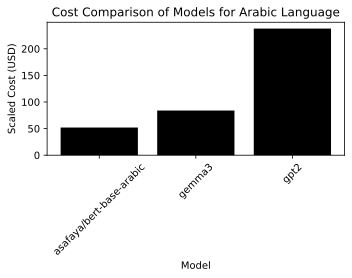

In [ ]:
# Define the models you want to compare
models = ["asafaya/bert-base-arabic", "gemma3", "gpt2"]
costs = []
language = "Arabic"  # Language to use for the cost comparison
# Calculate the token cost for each model using the sentences dictionary
for model in models:
    total_cost = 0
    tokens, _ = tokenize(sentences[language], model)
    total_cost = token_cost(tokens, model)
    costs.append(total_cost * 1000000)  # Scale by 1 million for display

# Create the bar plot
plt.figure(figsize=(5, 4))
plt.bar(models, costs, color='k')
plt.xlabel('Model')
plt.ylabel('Scaled Cost (USD)')
plt.title(f'Cost Comparison of Models for {language} Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 🧵 Key Takeaway

* **Be aware of how LLMs represent your language**, especially if you're using commercial APIs. The way your text is tokenized directly affects cost.
* If you're training your own LLM, **pay close attention to tokenization**. You might want to **adapt the tokenizer to your language** to reduce token count and make representation more compact and efficient.
* Recent work by **Cohere** explores building a [**universal tokenizer**](https://arxiv.org/pdf/2506.10766) that works well across multiple languages. This kind of research is trying to level the playing field.
* Also check out:

  * 📄 *[Do All Languages Cost the Same? Tokenization in the Era of Commercial Language Models](https://aclanthology.org/2023.emnlp-main.614.pdf)*
  * 📄 *[Language Model Tokenizers Introduce Unfairness Between Languages](https://arxiv.org/pdf/2305.154255)*

These studies highlighted early on that tokenizers introduced **structural unfairness**, especially for low-resource languages. Because of this, several commercial LLM providers have since started training **more representative tokenizers** to reduce token cost disparities across languages.

Bottom line: **Tokenization isn't just a technical detail, it's a language access issue.**


### From Words to Tokens: Why Order Matters

Consider these two phrase:

> I am happy

and

> Am I happy



In [ ]:
phrase1=" I am happy"
tokens, token_ids = tokenize(phrase1, model_name="gpt2")
print(set(token_ids))

{314, 716, 3772}


In [ ]:
phrase2=" am I happy"
tokens, token_ids = tokenize(phrase2, model_name="gpt2")
print(set(token_ids))

{314, 716, 3772}


Did you notice how these are exactly encoded similarly?!


**Drawback of using raw token**:

One drawback of using raw tokens is that they lack any indication of the word's position in the sequence. This is evident when considering sentences like "I am happy" and "Am I happy" - these two phrases have distinct meanings, and the model needs to grasp the word order to understand the intended message accurately.

To address this, when converting the inputs into vectors, position vectors are introduced and added to these vectors to indicate the **position** of each word. In the next section, we will discuss Positional Encoding - the last missing recipe needed for you to train your own language model.

## 🏗️ Training your own LLM (Transformers) [<font color='green'>Intermediate</font>] (30 minutes)

### Objective

* Load a dataset and train an LLM  
* Visualise positional encodings [<font color='orange'>Beginner</font>]  
* Implement:
  * Positional encodings  
  * FFN block  
  * Layer norm  
  * Decoder block  
  * Full LLM [<font color='green'>Intermediate</font>]  
* Define loss function  
* Load the training dataset  
* Write training script  
* Run inference on the trained model [<font color='orange'>Beginner</font>]


#### 2.2.2 Positional encodings

<img src="https://kazemnejad.com/img/transformer_architecture_positional_encoding/model_arc.jpg" alt="drawing" width="650"/>

By now, you should have a solid understanding of how attention works, as well as how words are tokenized and mapped into embeddings. These embeddings are vectors of numbers that represent each token.

However, it's important to understand one key limitation of self-attention mechanisms: it is **permutation invariant**. This means that, by default, attention has no way of knowing the position of each word in a sentence. As we know, word order is crucial in language modeling. To illustrate this, consider the following two sentences:

- "I have to read this book"  
- "I have this book to read"

Both sentences contain the exact same words (*look closely*), but their meanings are clearly different. This demonstrates that the position of words affects meaning. Since both the encoder and decoder blocks process all tokens in parallel, the original order of tokens would be lost without additional information. To give the model a sense of order, we add a small "position vector" to each word's embedding. These additional vectors are known as **positional encodings**. With positional encodings, each token carries information about both its meaning and its position in the sentence before the attention mechanism is applied.

An example of how positional encodings modify token embeddings is shown below.

\\

<figure>
  <img src="https://jalammar.github.io/images/t/transformer_positional_encoding_vectors.png" alt="Positional Encoding Vectors" width="650"/>
  <figcaption><em>To give the model a sense of word order, we add positional encoding vectors which follow a specific pattern. Source: https://jalammar.github.io/illustrated-transformer/ </em></figcaption>
</figure>

If we assume that the tokens get mapped to an embedding with a dimension D of 4, the positional encodings could look something like this:


<figure>
  <img src="https://jalammar.github.io/images/t/transformer_positional_encoding_example.png" alt="Positional Encoding Vectors" width="650"/>
  <figcaption><em>An example of positional encoding added to embedding dimension size of 4. Source: https://jalammar.github.io/illustrated-transformer/ </em></figcaption>
</figure>

Ideally, we want these positional encodings to contain certain desirable properties. ([Reference 1](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/), [Reference 2](https://huggingface.co/blog/designing-positional-encoding)):
1. **Each position has a unique and consistent encoding**  
   Every position in a sequence needs a distinct encoding vector. Importantly, this encoding should remain the same regardless of the overall length of the sequence. For example, position 5 should have the *same* encoding whether the input sequence has 10 tokens or 10,000.

2. **Linear relationships between positions**  
   The difference between encodings should reflect the distance between positions. Think of a number line: if position 3 is two steps from 1, and position 6 is three steps from 3, the encoding should preserve those kinds of relationships. This helps the model reason about relative positions in a sentence.

3. **Generalises to unseen (longer) sequences**  
   The encoding scheme should still work when the model is given longer sequences than it was trained on. In other words, it should not “break” when encountering inputs longer than expected.

4. **Deterministic, not random**  
   The encodings must come from a fixed, repeatable rule (not randomness).  
   This helps the model learn the pattern of the encoding and use it effectively.

##### **Sine and cosine functions**

To meet the desirable properties discussed above, the authors of [*Attention is All You Need*](https://arxiv.org/pdf/1706.03762) propose a simple technique for **positional encoding**. This method injects information about token order into embeddings by applying a combination of sine and cosine functions at varying frequencies.

The position encoding for a given position `pos`, at embedding dimension index `i`, with total embedding size `d_model`, is defined as:

$$
PE_{\text{pos}, i} =
\begin{cases}
\sin\left(\frac{\text{pos}}{10000^{i / d_{\text{model}}}}\right), & \text{if } i \bmod 2 = 0 \\
\cos\left(\frac{\text{pos}}{10000^{(i - 1) / d_{\text{model}}}}\right), & \text{if } i \bmod 2 = 1
\end{cases}
$$

Assuming a model with embedding size \( d_{\text{model}} = 8 \), the positional encoding vector for position `pos` becomes:

$$
PE_{\text{pos}} =
\begin{bmatrix}
\sin\left(\frac{\text{pos}}{10000^{0 / 8}}\right) \\
\cos\left(\frac{\text{pos}}{10000^{0 / 8}}\right) \\
\sin\left(\frac{\text{pos}}{10000^{2 / 8}}\right) \\
\cos\left(\frac{\text{pos}}{10000^{2 / 8}}\right) \\
\sin\left(\frac{\text{pos}}{10000^{4 / 8}}\right) \\
\cos\left(\frac{\text{pos}}{10000^{4 / 8}}\right) \\
\sin\left(\frac{\text{pos}}{10000^{6 / 8}}\right) \\
\cos\left(\frac{\text{pos}}{10000^{6 / 8}}\right)
\end{bmatrix}
$$

> **Note:** Even indices use sine, and odd indices use cosine. The division by powers of 10000 ensures that each dimension encodes a different frequency.



To understand why these encodings work in practice, let's create a function to visualize them and play around with the `token_sequence_length` and the `token_embedding` dimension.


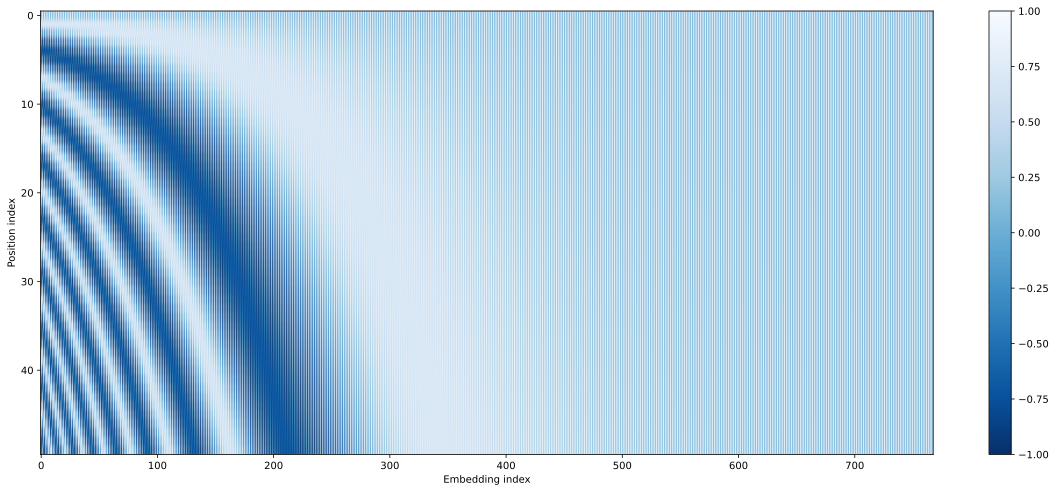

In [ ]:
def return_frequency_pe_matrix(token_sequence_length, token_embedding):

  assert token_embedding % 2 == 0, "token_embedding should be divisible by two"

  P = jnp.zeros((token_sequence_length, token_embedding))
  positions = jnp.arange(0, token_sequence_length)[:, jnp.newaxis]

  i = jnp.arange(0, token_embedding, 2)
  frequency_steps = jnp.exp(i * (-math.log(10000.0) / token_embedding))
  frequencies = positions * frequency_steps

  P = P.at[:, 0::2].set(jnp.sin(frequencies))
  P = P.at[:, 1::2].set(jnp.cos(frequencies))

  return P

token_sequence_length = 50 # @param {type: "number"}
token_embedding = 768  # @param {type: "number"}
P = return_frequency_pe_matrix(token_sequence_length, token_embedding)
plot_position_encodings(P, token_sequence_length, token_embedding)

Notice how every row in the graph, corresponding to a specific token position displays a distinct wave pattern across the embedding dimensions. This means each position has a fixed and unique encoding, which allows the model to distinguish tokens based on their position in the sequence. The encodings don’t change between runs; they’re entirely determined by the formula.

### 🤔 **Group Activity**:

- <font color='blue'>Take a moment with your friend to explore why this specific pattern appears when `token_sequence_length` is set to 1000, and `token_embedding` is 768.</font>
- <font color='blue'>Experiment with smaller values for `token_sequence_length` and `token_embedding` to build a deeper understanding and enhance your discussion.</font>
- <font color='blue'>Curious about the constant 10000? Ask your friend why they think it’s used in the functions above.</font>
- <font color='blue'>Now, try setting `token_sequence_length` to 50 and `token_embedding` to a much larger value, like 10000. What do you observe? Do we always need a large token embedding?</font>


### 2.3 Transformer block   <font color='green'>Intermediate</font>

Just like an MLP (a simple neural network that processes input data through multiple layers) or a CNN (a type of neural network that excels at recognizing patterns in images by using convolution layers), transformers are made up of a stack of transformer blocks. In this section, we'll build each of the components needed to create one of these transformer blocks.


#### 2.3.1 Feed Forward Network (FFN) / Multilayer perceptron (MLP) <font color='orange'>Beginner</font>


<div style="display: flex; align-items: center; justify-content: center; gap: 40px;">
  <img src="https://drive.google.com/uc?export=view&id=1gyHqjfJUg_BLoFhAH6_KqsKxOQWvYtvD" alt="Feed Forward Neural Network" width="300"/>
  <img src="https://drive.google.com/uc?export=view&id=1H1pVFxJiSpM_Ozj1eKWNdcFQ5Hn5XsZz" alt="Drawing" width="260"/>
</div>



In the original model, these blocks consist of a simple 2-layer MLP (Multi-Layer Perceptron) that uses ReLU activation. However, GeLU (Gaussian Error Linear Unit) has become very popular, and we will be using it throughout this practical. The formula below represents the feedforward neural network (FFN) with GeLU activation. In this network, the input `x` is first passed through two linear layers with weights `W1` and `W2`, followed by bias terms `b1` and `b2`. The ReLU activation function, often represented by the `max` function, is replaced by the GeLU activation function in this case.

$$
\operatorname{FFN}(x)=\max \left(0, x W_{1}+b_{1}\right) W_{2}+b_{2}
$$

One can interpret this block as processing what the multi-head attention block has produced and then projecting these new token representations to a space that the next block can use more optimally. Usually, the first layer is very wide, in the range of 2-8 times the size of the token representations. They do this as it is easier to parallelize computations for a single wider layer during training than to parallelize a feedforward block with multiple layers. Thus they can add in more complexity but keep training and inference optimized.

In [ ]:
# @title Code implementation for a feed forward neural network (Run me!)

class FeedForwardBlock(nn.Module):
    """
    A 2-layer MLP which widens then narrows the input.

    Args:
      widening_factor [optional, default=4]: The size of the hidden layer will be d_model * widening_factor.
    """
    # widening_factor controls how much the input dimension is expanded in the first layer.
    widening_factor: int = 4

    # init_scale controls the scaling factor for weight initialization.
    init_scale: float = 0.25

    @nn.compact
    def __call__(self, x):
        # Get the size of the last dimension of the input (embedding size).
        d_m = x.shape[-1]

        # Calculate the size of the first layer by multiplying the embedding size by the widening factor.
        layer1_size = self.widening_factor * d_m

        # Initialize the weights for both layers using a variance scaling initializer.
        initializer = nn.initializers.variance_scaling(
            scale=self.init_scale, mode='fan_in', distribution='truncated_normal',
        )

        # Define the first dense layer, which expands the input size.
        layer1 = nn.Dense(layer1_size, kernel_init=initializer)

        # Define the second dense layer, which reduces the size back to the original dimension.
        layer2 = nn.Dense(d_m, kernel_init=initializer)

        # Apply the first dense layer followed by a GELU activation function.
        x = jax.nn.gelu(layer1(x))

        # Apply the second dense layer to project the data back to its original dimension.
        x = layer2(x)

        # Return the final output.
        return x

#### 2.3.2 Add and Norm block <font color='orange'>Beginner</font>

<div style="display: flex; align-items: center; justify-content: center; gap: 40px;">
  <img src="https://drive.google.com/uc?export=view&id=1lj8pqO6ttjbcTRUEW1rbtRlueiLPxoSr" alt="Feed Forward Neural Network" width="300"/>
  <img src="https://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png" alt="Drawing" width="400"/>
</div>


In order to get transformers to go deeper, the residual connections are very important to allow an easier flow of gradients through the network. For normalisation, `layer norm` is used. This normalises each token vector independently in the batch. It is found that normalising the vectors improves the convergence and stability of transformers.

There are two learnable parameters in layernorm, `scale` and `bias`, which rescales the normalised value. Thus, for each input token in a batch, we calculate the mean, $\mu_{i}$ and variance $\sigma_i^2$. We then normalise the token with:

$\hat{x}_i = \frac{x_i-\mu_{i}}{\sigma_i^2 + ϵ}$.

Then $\hat{x}$ is rescaled using the learned `scale`, $γ$, and `bias` $β$, with:

$y_i = γ\hat{x}_i + β = LN_{γ,β}(x_i)$.

So our add norm block can be represented as $LN(x+f(x))$, where $f(x)$ is either a MLP or MHA block.

To implement the Add & Norm block, we define a Flax module that takes in the original and processed inputs, adds them together, and then applies flax.linen.LayerNorm across the last dimension to normalize the result. This helps stabilize training by standardizing the summed representation.

In [ ]:
# @title Code implementation for Add and Norm block (Run me!)

class AddNorm(nn.Module):
    """A block that implements the 'Add and Norm' operation"""

    @nn.compact
    def __call__(self, x, processed_x):
        # Step 1: Add the original input (x) to the processed input (processed_x).
        added = x + processed_x

        # Step 2: Apply layer normalization to the result of the addition.
        # - LayerNorm helps to stabilize and improve the training process by normalizing the output.
        # - reduction_axes=-1 indicates that normalization is applied across the last dimension (typically the embedding dimension).
        # - use_scale=True and use_bias=True allow the layer to learn scaling and bias parameters for further fine-tuning.
        normalised = nn.LayerNorm(reduction_axes=-1, use_scale=True, use_bias=True)

        # Return the normalized result.
        return normalised(added)

### 2.4 Building the Transformer Decoder / LLM <font color='green'>Intermediate</font>

<img src="https://drive.google.com/uc?export=view&id=1MubUcshJTHCqOPTRHixLhrYYLXX9vP_h" alt="drawing" width="260"/>

Most of the groundwork has happened. We have built the positional encoding block, the MHA block, the feed-forward block and the add&norm block.

The only part needed is passing inputs to each decoder block and applying the masked MHA block found in the decoder blocks.

**Code task:** Code up a FLAX Module that implements the (FFN(norm(MHA(norm(X))))) for the decoder block

In [ ]:
#@title Decoder Block Implementation

class DecoderBlock(nn.Module):
    """
    Transformer decoder block.

    Args:
        num_heads: The number of attention heads in the Multi-Head Attention (MHA) block.
        d_m: The size of the token embeddings.
        widening_factor: The factor by which the hidden layer size is expanded in the MLP.
    """

    num_heads: int
    d_m: int
    widening_factor: int = 4

    def setup(self):
        # Initialize the Multi-Head Attention (MHA) block
        self.mha = MultiHeadAttention(self.num_heads, self.d_m)

        # Initialize the AddNorm blocks for residual connections and normalization
        self.add_norm1 = AddNorm()  # First AddNorm block after MHA
        self.add_norm2 = AddNorm()  # Second AddNorm block after the MLP

        # Initialize the FeedForwardBlock (MLP) which processes the data after attention
        self.MLP = FeedForwardBlock(widening_factor=self.widening_factor)

    def __call__(self, X, mask=None, return_att_weight=True):
        """
        Forward pass through the DecoderBlock.

        Args:
            X: Batch of input tokens fed into the decoder, shape [B, T_decoder, d_m]
            mask [optional, default=None]: Mask to control which positions the attention is allowed to consider, shape [T_decoder, T_decoder].
            return_att_weight [optional, default=True]: If True, returns the attention weights along with the output.

        Returns:
            If return_att_weight is True, returns a tuple (X, attention_weights_1).
            Otherwise, returns the processed token representations X.
        """

        # Apply Multi-Head Attention to the input tokens (X) with optional masking
        attention, attention_weights_1 = self.mha(X, mask=mask, return_weights=True)

        # Apply the first AddNorm block (adds the original input X and normalizes)
        X = self.add_norm1(X, attention)

        # Pass the result through the FeedForwardBlock (MLP) to further process the data
        projection = self.MLP(X)

        # Apply the second AddNorm block (adds the input from the previous step and normalizes)
        X = self.add_norm2(X, projection)

        # Return the final output X, and optionally the attention weights
        return (X, attention_weights_1) if return_att_weight else X


Next, we just put everything together, adding in the positional encodings as well as stacking multiple transformer blocks and adding our prediction layer.

In [ ]:
class LLM(nn.Module):
    """
    Transformer model consisting of several layers of decoder blocks.

    Args:
        num_heads: Number of attention heads in each Multi-Head Attention (MHA) block.
        num_layers: Number of decoder blocks in the model.
        d_m: Dimensionality of the token embeddings.
        vocab_size: Size of the vocabulary (number of unique tokens).
        widening_factor: Factor by which the hidden layer size is expanded in the MLP.
    """
    num_heads: int
    num_layers: int
    d_m: int
    vocab_size: int
    widening_factor: int = 4

    def setup(self):
        # Initialize a list of decoder blocks, one for each layer in the model
        self.blocks = [
            DecoderBlock(self.num_heads, self.d_m, self.widening_factor)
            for _ in range(self.num_layers)
        ]

        # Initialize an embedding layer to convert token IDs into token embeddings
        self.embedding = nn.Embed(num_embeddings=self.vocab_size, features=self.d_m)

        # Initialize a dense layer for predicting the next token in the sequence
        self.pred_layer = nn.Dense(self.vocab_size)

    def __call__(self, X, mask=None, return_att_weights=False):
        """
        Forward pass through the LLM model.

        Args:
            X: Batch of input token IDs, shape [B, T_decoder] where B is batch size and T_decoder is sequence length.
            mask [optional, default=None]: Mask to control which positions the attention can focus on, shape [T_decoder, T_decoder].
            return_att_weights [optional, default=False]: Whether to return the attention weights.

        Returns:
            logits: The predicted probabilities for each token in the vocabulary.
            If return_att_weights is True, also returns the attention weights.
        """

        # Convert token IDs to embeddings (shape [B, T_decoder, d_m])
        X = self.embedding(X)

        # Get the sequence length of the input
        sequence_len = X.shape[-2]

        # Generate positional encodings and add them to the token embeddings
        positions = return_frequency_pe_matrix(sequence_len, self.d_m)
        X = X + positions

        # Initialize a list to store attention weights if needed
        if return_att_weights:
            att_weights = []

        # Pass the embeddings through each decoder block in sequence
        for block in self.blocks:
            out = block(X, mask, return_att_weights)
            if return_att_weights:
                # If returning attention weights, unpack the output
                X = out[0]
                att_weights.append(out[1])
            else:
                # Otherwise, just update the input for the next block
                X = out

        # Apply a dense layer followed by a log softmax to get logits (predicted token probabilities)
        logits = nn.log_softmax(self.pred_layer(X))

        # Return the logits, and optionally, the attention weights
        return logits if not return_att_weights else (logits, jnp.array(att_weights).swapaxes(0, 1))

If everything is correct, then if we run the code below, everything should run without any issues.

In [ ]:
# Define model dimensions and input shapes
batch_size = 18
sequence_length = 32
embedding_dim = 16
num_decoder_layers = 8
vocab_size = 25670

# Initialize the language model
llm = LLM(
    num_heads=1,
    num_layers=1,
    d_m=embedding_dim,
    vocab_size=vocab_size,
    widening_factor=4
)

# Create a lower-triangular attention mask for causal decoding
causal_mask = jnp.tril(np.ones((sequence_length, sequence_length)))

# Generate random input token IDs
rng_key = jax.random.PRNGKey(42)
input_token_ids = jax.random.randint(rng_key, [batch_size, sequence_length], 0, vocab_size)

# Initialize model parameters
model_params = llm.init(rng_key, input_token_ids, mask=causal_mask)

# Run the model and extract logits and attention weights from the decoder
logits, decoder_attention_weights = llm.apply(
    model_params,
    input_token_ids,
    mask=causal_mask,
    return_att_weights=True,
)

As a final sanity check, we can confirm that our attention weights are working correctly. As shown in the figure below, the decoder's attention weights only focus on previous tokens, as expected.

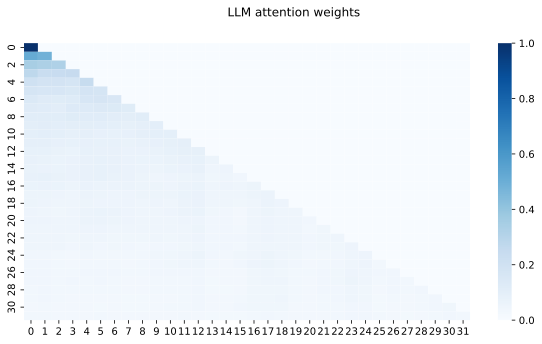

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.suptitle("LLM attention weights")
sns.heatmap(decoder_attention_weights[0, 0, 0, ...], ax=ax, cmap="Blues")
fig.show()

### 2.5 Training your LLM

#### 2.5.1 Training objective [<font color='green'>Intermediate</font>]


A sentence is nothing but a string of words. A LLM aims to predict the next word by considering the current context, namely the words that have come before.

Here's the basic idea:

To calculate the probability of a full sentence "word1, word2, ..., last word" appearing in a given context $c$, the procedure is to break down the sentence into individual words and consider the probability of each word given the words that precede it. These individual probabilities are then multiplied together:

$$\text{Probability of sentence} = \text{Probability of word1} \times \text{Probability of word2} \times \ldots \times \text{Probability of last word}$$

This method is akin to building up a narrative one piece at a time based on the preceding storyline.

Mathematically, this is expressed as the likelihood (probability) of a sequence of words $y_1, y_2, ..., y_n$ in a given context $c$, which is achieved by multiplying the probabilities of each word $y_t$ calculated given the predecessors ($y_{<t}$) and the context $c$:

$$
P\left(y_{1}, y_{2}, \ldots, y_{n}, \mid c\right)=\prod_{t=1}^{n} P\left(y_{t} \mid y_{<t}, c\right)
$$

Here $y_{<t}$ stands for the sequence $y_1, y_2, ..., y_{t-1}$, while $c$ represents the context.

This is analogous to solving a jigsaw puzzle where the next piece is predictively placed based on what's already in place.

Remember just when training a transformer, we do not work in words, but in tokens. During the training process, the model's parameters are fine-tuned by computing the cross-entropy loss across the predicted token, and the correct token, and then performing backpropagation. The loss for time step "t" is computed as:

$$ \text{Loss}_t = - \sum_{w \in V} y_t\log (\hat{y}_t) $$

Here $y_t$ is the actual token at time step $t$, and $\hat{y}_t$ is the token predicted by the model at the same time step. The loss for the entire sentence is then computed as:

$$ \text{Sentence Loss} = \frac{1}{n} \sum^{n}_{t=1} \text{Loss}_t $$

where $n$ is the length of the sequence.

This iterative process ultimately hones the model's predictive capabilities over time.

**Code task**: Implement the cross-entropy loss function below.

In [ ]:
def sequence_loss_fn(logits, targets):
  '''
  Compute the cross-entropy loss between predicted token ID and true ID.

  Args:
    logits: An array of shape [batch_size, sequence_length, vocab_size]
    targets: The targets we are trying to predict

  Returns:
    loss: A scalar value representing the mean batch loss
  '''

  target_labels = jax.nn.one_hot(targets, VOCAB_SIZE)
  assert logits.shape == target_labels.shape

  mask = jnp.greater(targets, 0)

  # Hint: Compute the cross-entropy loss by first applying `jax.nn.log_softmax(logits)`
  # to get the log probabilities for each class. Then, multiply these log probabilities
  # by the `target_labels` to focus on the correct class's probability. Sum this result
  # along the last axis to get the loss for each token. Finally, apply the mask to the loss,
  # sum the masked losses, and normalize by the number of non-padding tokens.
  loss = ...# FINISH ME

  return loss

In [ ]:
# @title Run me to test your code
VOCAB_SIZE = 25670
targets = jnp.array([[0, 2, 0]])
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [1, 3, VOCAB_SIZE])
loss = sequence_loss_fn(X, targets)
real_loss = jnp.array(10.966118)

try:
  jnp.allclose(real_loss, loss)
  print("It seems correct. Look at the answer below to compare methods.")
except:
  print("Not returning the correct value")

Not returning the correct value


In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def sequence_loss_fn(logits, targets):
    """Compute the sequence loss between predicted logits and target labels."""

    # Convert the target indices to one-hot encoded vectors.
    # Each target label is converted into a one-hot vector of size VOCAB_SIZE.
    target_labels = jax.nn.one_hot(targets, VOCAB_SIZE)

    # Ensure that the shape of logits matches the shape of the one-hot encoded targets.
    # This is important because we need to compute the loss across matching dimensions.
    assert logits.shape == target_labels.shape

    # Create a mask that ignores padding tokens in the loss calculation.
    # The mask is True (1) where the target value is greater than 0 and False (0) otherwise.
    mask = jnp.greater(targets, 0)

    # Compute the cross-entropy loss for each token.
    # Cross-entropy is calculated as the negative log probability of the correct class.
    # jax.nn.log_softmax(logits) gives us the log probabilities for each class.
    # We multiply by the target_labels to select the log probability of the correct class.
    loss = -jnp.sum(target_labels * jax.nn.log_softmax(logits), axis=-1)

    # Apply the mask to the loss to ignore padding positions and sum up the losses.
    # We then normalize the total loss by the number of non-padding tokens.
    loss = jnp.sum(loss * mask) / jnp.sum(mask)

    return loss

#### 2.5.2 Training models [<font color='green'>Intermediate</font>]

In the next section, we define all the processes required to train the model using the objective described above. A lot of this is now the work required to do training using FLAX.

Below we gather the dataset and we shall be training on, which is Karpathy's shakespeare dataset. Its not so important to understand this code, so either just run the cell to load the data, or view the code if you want to understand it.


In [ ]:
# @title Create Shakespeare dataset and iterator (optional, but run the cell)

# Trick to avoid errors when downloading tinyshakespeare.
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O input.txt

class WordBasedAsciiDatasetForLLM:
    """In-memory dataset of a single-file ASCII dataset for language-like model."""

    def __init__(self, path: str, batch_size: int, sequence_length: int):
        """Load a single-file ASCII dataset in memory."""
        self._batch_size = batch_size

        with open(path, "r") as f:
            corpus = f.read()

        # Tokenize by splitting the text into words
        words = corpus.split()
        self.vocab_size = len(set(words))  # Number of unique words

        # Create a mapping from words to unique IDs
        self.word_to_id = {word: i for i, word in enumerate(set(words))}

        # Store the inverse mapping from IDs to words
        self.id_to_word = {i: word for word, i in self.word_to_id.items()}

        # Convert the words in the corpus to their corresponding IDs
        corpus = np.array([self.word_to_id[word] for word in words]).astype(np.int32)

        crop_len = sequence_length + 1
        num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
        if ragged:
            corpus = corpus[:-ragged]
        corpus = corpus.reshape([-1, crop_len])

        if num_batches < 10:
            raise ValueError(
                f"Only {num_batches} batches; consider a shorter "
                "sequence or a smaller batch."
            )

        self._ds = WordBasedAsciiDatasetForLLM._infinite_shuffle(
            corpus, batch_size * 10
        )

    def __iter__(self):
        return self

    def __next__(self):
        """Yield next mini-batch."""
        batch = [next(self._ds) for _ in range(self._batch_size)]
        batch = np.stack(batch)
        # Create the language modeling observation/target pairs.
        return dict(
            input=batch[:, :-1], target=batch[:, 1:]
        )

    def ids_to_words(self, ids):
        """Convert a sequence of word IDs to words."""
        return [self.id_to_word[id] for id in ids]

    @staticmethod
    def _infinite_shuffle(iterable, buffer_size):
        """Infinitely repeat and shuffle data from iterable."""
        ds = itertools.cycle(iterable)
        buf = [next(ds) for _ in range(buffer_size)]
        random.shuffle(buf)
        while True:
            item = next(ds)
            idx = random.randint(0, buffer_size - 1)  # Inclusive.
            result, buf[idx] = buf[idx], item
            yield result


--2025-06-27 11:26:44--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-06-27 11:26:44 (27.6 MB/s) - ‘input.txt’ saved [1115394/1115394]



Lets now look how our data is structured for training

In [ ]:
# sample and look at the data
batch_size = 2
seq_length = 32
train_dataset = WordBasedAsciiDatasetForLLM("input.txt", batch_size, seq_length)

batch = next(train_dataset)

for obs, target in zip(batch["input"], batch["target"]):
    print("-" * 10, "Input", "-" * 11)
    print("TEXT:", ' '.join(train_dataset.ids_to_words(obs)))
    print("ASCII:", obs)
    print("-" * 10, "Target", "-" * 10)
    print("TEXT:", ' '.join(train_dataset.ids_to_words(target)))
    print("ASCII:", target)

print(f"\n Total vocabulary size: {train_dataset.vocab_size}")

VOCAB_SIZE = train_dataset.vocab_size

---------- Input -----------
TEXT: you what services he has done for his country? First Citizen: Very well; and could be content to give him good report fort, but that he pays himself with being proud. Second
ASCII: [17387  2238  8362 14630  8395 20989 14039  6474 24643  1815  8852  8861
 15110 20511 17683  5777   531 24092 17764  8746  6893 11906  2812  7793
 20238 14630 12627   915  2932 11426  3510 20612]
---------- Target ----------
TEXT: what services he has done for his country? First Citizen: Very well; and could be content to give him good report fort, but that he pays himself with being proud. Second Citizen:
ASCII: [ 2238  8362 14630  8395 20989 14039  6474 24643  1815  8852  8861 15110
 20511 17683  5777   531 24092 17764  8746  6893 11906  2812  7793 20238
 14630 12627   915  2932 11426  3510 20612  8852]
---------- Input -----------
TEXT: cared for us yet: suffer us to famish, and their store-houses crammed with grain; make edicts for usury, to support usurers; repeal dail

Next, let us train our LLM and see how it performs in producing Shakespearian text. First, we will define what happens for every training step.

In [ ]:
import functools

@functools.partial(jax.jit, static_argnums=(3, 4))
def train_step(params, optimizer_state, batch, apply_fn, update_fn):
    """
    Perform a single training step.

    Args:
        params: The current parameters of the model.
        optimizer_state: The current state of the optimizer.
        batch: A dictionary containing the input data and target labels for the batch.
        apply_fn: The function used to apply the model to the inputs.
        update_fn: The function used to update the model parameters based on the gradients.

    Returns:
        Updated parameters, updated optimizer state, and the computed loss for the batch.
    """

    def loss_fn(params):
        # Get the sequence length (T) from the input data.
        T = batch['input'].shape[1]

        # Apply the model to the input data, using a lower triangular mask to enforce causality.
        # jnp.tril(np.ones((T, T))) creates a lower triangular matrix of ones.
        logits = apply_fn(params, batch['input'], jnp.tril(np.ones((T, T))))

        # Calculate the loss between the predicted logits and the target labels.
        loss = sequence_loss_fn(logits, batch['target'])

        return loss

    # Compute the loss and its gradients with respect to the parameters.
    loss, gradients = jax.value_and_grad(loss_fn)(params)

    # Update the optimizer state and calculate the parameter updates based on the gradients.
    updates, optimizer_state = update_fn(gradients, optimizer_state)

    # Apply the updates to the parameters.
    params = optax.apply_updates(params, updates)

    # Return the updated parameters, optimizer state, and the loss for the batch.
    return params, optimizer_state, loss

Next we initialise our optimizer and model. Feel free to play with the hyperparameters during the practical.

In [ ]:
# Define all hyperparameters
d_model = 128            # Dimension of token embeddings (d_m)
num_heads = 4            # Number of attention heads in Multi-Head Attention
num_layers = 1           # Number of decoder blocks in the model
widening_factor = 2      # Factor to widen the hidden layer size in the MLP
LR = 2e-3                # Learning rate for the optimizer
batch_size = 32          # Number of samples per training batch
seq_length = 64          # Length of each input sequence (number of tokens)

# Set up the training data
train_dataset = WordBasedAsciiDatasetForLLM("input.txt", batch_size, seq_length)
vocab_size = train_dataset.vocab_size  # Get the size of the vocabulary from the dataset
batch = next(train_dataset)            # Get the first batch of input data

# Set the random number generator key for model initialization
rng = jax.random.PRNGKey(42)

# Initialize the LLM model with the specified hyperparameters
llm = LLM(num_heads=num_heads, num_layers=num_layers, d_m=d_model, vocab_size=vocab_size, widening_factor=widening_factor)

# Create a causal mask to ensure that the model only attends to previous tokens
mask = jnp.tril(np.ones((batch['input'].shape[1], batch['input'].shape[1])))

# Initialize the model parameters using the first batch of input data and the mask
params = llm.init(rng, batch['input'], mask)

# Set up the optimizer using the Adam optimization algorithm with the specified learning rate
optimizer = optax.adam(LR, b1=0.9, b2=0.99)
optimizer_state = optimizer.init(params)  # Initialize the optimizer state with the model parameters

Now we train! This will take a few minutes.. While it trains, have you greeted your neighbour yet?

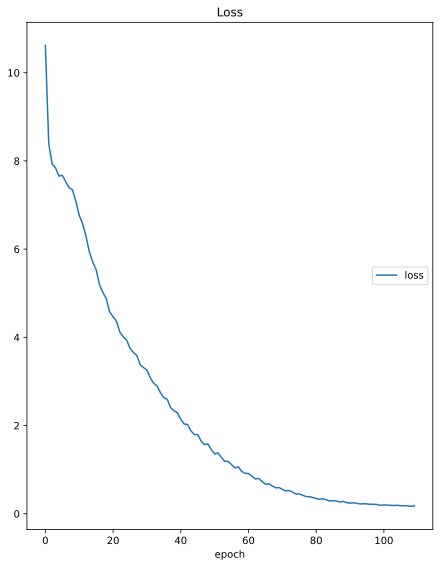

Loss
	loss             	 (min:    0.167, max:   10.620, cur:    0.180)


In [ ]:
plotlosses = PlotLosses()

MAX_STEPS = 3500
LOG_EVERY = 32
losses = []
VOCAB_SIZE = 25670

# Training loop
for step in range(MAX_STEPS):
    batch = next(train_dataset)
    params, optimizer_state, loss = train_step(
        params, optimizer_state, batch, llm.apply, optimizer.update)
    losses.append(loss)
    if step % LOG_EVERY == 0:
        loss_ = jnp.array(losses).mean()
        plotlosses.update(
            {
                "loss": loss_,
            }
        )
        plotlosses.send()
        losses = []

#### 2.5.3 Inspecting the trained LLM [<font color='orange'>Beginner</font>]


**Reminder:** remember to run all code presented so far in this section before runnning the cells below!

Lets generate some text now and see how our model did. DO NOT STOP THE CELL ONCE IT IS RUNNING, THIS WILL CHRASH THE SESSION.

In [ ]:
import functools

@functools.partial(jax.jit, static_argnums=(2, ))
def generate_prediction(params, input, apply_fn):
  logits = apply_fn(params, input)
  argmax_out = jnp.argmax(logits, axis=-1)
  return argmax_out[0][-1].astype(int)

def generate_random_shakespeare(llm, params, id_2_word, word_2_id):
    '''
    Get the model output
    '''

    prompt = "Love"
    print(prompt, end="")
    tokens = prompt.split()

    # predict and append
    for i in range(15):
      input = jnp.array([[word_2_id[t] for t in tokens]]).astype(int)
      prediction = generate_prediction(params, input, llm.apply)
      prediction = id_2_word[int(prediction)]
      tokens.append(prediction)
      print(" "+prediction, end="")

    return " ".join(tokens)

id_2_word = train_dataset.id_to_word
word_2_id = train_dataset.word_to_id

generated_shakespeare = generate_random_shakespeare(llm, params, id_2_word, word_2_id)

Love you or of your yourself, you do not swear your hands: I am not desire

Finally, we implemented everything above by taking the token ID with the maximum probability of being correct. This is greedy decoding, as we only took the most likely token. It worked well in this use case, but there are cases where we will see a degrading performance when taking this greedy approach, specifically when we are interested in generating realistic text.

Other methods exist for sampling from the decoder, with a famous algorithm being beam search. We provide resources below for anyone interested in learning more about this.

[Greedy Decoding](https://www.youtube.com/watch?v=DW5C3eqAFQM&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=4)

[Beam Search](https://www.youtube.com/watch?v=uG3xoYNo3HM&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=5)

# **Conclusion**
**Summary:**

You've now mastered the essentials of how a Large Language Model (LLM) works, from the fundamentals of attention mechanisms to training your own LLM! These powerful tools have the potential to transform a wide range of tasks. However, like any deep learning model, their magic lies in applying them to the right problems with the right data.

Ready to take your skills to the next level? Dive into fine-tuning your own LLMs and unleash even more potential! I highly recommend exploring last year's practical on Parameter Efficient Fine-Tuning Methods for a comprehensive overview of advanced techniques. The journey doesn't stop here—there's so much more to discover!

The world of LLMs is yours to explore—go ahead and create something amazing! 🌟🚀



**Next Steps:**
[**Efficiently Finetuning LLMs with Hugging Face**](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/large_language_models.ipynb)


**References:** for further references check the links referenced throughout
specific sections of this colab.

* [Attention is all you need paper](https://arxiv.org/abs/1706.03762)
* [Additional videos on transformers](https://www.youtube.com/playlist?list=PLmZlBIcArwhOPR2s-FIR7WoqNaBML233s)
* [LoRA paper](https://arxiv.org/abs/2106.09685)
* [RLHF](https://huggingface.co/blog/rlhf) (how ChatGPT was trained)
* [Extending context length](https://kaiokendev.github.io/context):
* [LLMs for Everyone DLI2023](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/large_language_models.ipynb)
* [Foundations of LLM DLI2024](https://github.com/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/Foundations_of_LLMs/foundations_of_llms_practical.ipynb)


For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2025).

# Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />